
**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2023**

---
## Trabajo práctico entregable - Parte 1

In [1]:
import io
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from pandasql import sqldf

pysqldf = lambda q: sqldf(q, globals())


sns.set_context('talk')

## Lectura del dataset

In [2]:
url = 'https://raw.githubusercontent.com/DiploDatos/AnalisisyVisualizacion/master/sysarmy_survey_2022_processed.csv'
df = pd.read_csv(url)

# Ejercicio 1 - Análisis descriptivo
 
### ¿Cuáles son los lenguajes de programación asociados a los mejores salarios?

Seleccionamos como columnas del puesto de trabajo, los lenguajes de programación utlizados, salario bruto y salario neto. 

In [3]:
# complete here if you want to include more columns
relevant_columns = ['Trabajo de','tools_programming_languages','salary_monthly_BRUTO','salary_monthly_NETO','profile_years_experience']


A continuación, nos concentramos en hacer una limpieza de los datos. Primero un análisis por percentiles para la eliminación de valores extremos, centrados en el salario neto.



In [4]:
#Revisamos cuales son las posiciones más relevantes. Para ello agrupamos la columna "Trabajo de", vemos cuantos registros posee
#y calculamos la proporción de los encuestados que quedan agrupados en cada categoría.
#CRITERIO: se seleccionan los primeros 15 puestos que acumulan el 80% de los casos
cl = pysqldf("""
                SELECT  df.'Trabajo de' as position,
                        COUNT(df.'Trabajo de') as count,
                        COUNT(df.'Trabajo de') *100/(SELECT COUNT(df.'Trabajo de') FROM df) as share
                FROM df
                GROUP BY position
                ORDER BY count DESC
                LIMIT 15;
        
        """)
top_80 = cl.position.unique()


#Se filtra por aquellas posiciones que representan el 80% de los casos 
df1 = df[relevant_columns]
df1 = df1[df1['Trabajo de'].isin(top_80)]

#Se conservan registros cuya diferencia entre salario bruto y neto sea positiva.
#Por otro lado, se eliminan registros cuyo valor de salario sea menor a 10.000 pesos
df1 = pysqldf("""
              SELECT df.'Trabajo de',
                     df.tools_programming_languages,
                     df.salary_monthly_BRUTO,
                     df.salary_monthly_NETO,
                     df.profile_gender,
                     df.profile_years_experience
                     
              FROM df
              
              WHERE df.salary_monthly_BRUTO-salary_monthly_NETO>0
              AND df.salary_monthly_BRUTO > 10000
              AND df.salary_monthly_NETO > 10000;
        """)

In [5]:
# Eliminamos datos extremos, utilizaremos los cuartiles como medida para encontrar los maximos y minimos
# Calularemos los percentiles 90 a 99 y seleccionaremos uno:

p90 = df1['salary_monthly_NETO'].quantile(0.90)
p95 = df1['salary_monthly_NETO'].quantile(0.95)
p97 = df1['salary_monthly_NETO'].quantile(0.97)
p99 = df1['salary_monthly_NETO'].quantile(0.99)

#quantiles = DataFrame

qdata = {'salary_quantile': [p90, p95, p97, p99]}


# Consultemos la cantidad de datos que tenemos con respecto a los percentiles 97 y 99:
p95_data = df1[df1['salary_monthly_NETO'] > df1['salary_monthly_NETO'].quantile(0.95)]
p97_data = df1[df1['salary_monthly_NETO'] > df1['salary_monthly_NETO'].quantile(0.97)]
p99_data = df1[df1['salary_monthly_NETO'] > df1['salary_monthly_NETO'].quantile(0.99)]
p95_q = len(p95_data) - (len(p97_data) - len(p99_data))
qdata_rows = {'Unique row quantity': [p95_q, len(p97_data) - len(p99_data), len(p99_data)]}



print(pd.DataFrame(data=qdata, index=['p90', 'p95', 'p97', 'p99']), '\n\n',
      pd.DataFrame(data=qdata_rows, index=['p95' ,'p97', 'p99']))

     salary_quantile
p90         450000.0
p95         651780.4
p97         858547.5
p99        1352340.0 

      Unique row quantity
p95                  126
p97                   83
p99                   42


Si bien vemos que la suma de las filas unicas de los percentiles 97 y 99 da muy cercana al del percentil 95. Creemos que el sueldo que nos indica el percentil 97 es muy alto. Por lo que seleccionamos como límite superior el sueldo alcanzado por el percentil 95. 

In [7]:
p10 = df1['salary_monthly_NETO'].quantile(0.10)
p15 = df1['salary_monthly_NETO'].quantile(0.15)
p20 = df1['salary_monthly_NETO'].quantile(0.20)
p25 = df1['salary_monthly_NETO'].quantile(0.25)

#quantiles = DataFrame

qdata = {'salary_quantile': [p10, p15, p20, p25]}



p10_data = df1[(df1['salary_monthly_NETO'] < df1['salary_monthly_NETO'].quantile(0.10)) & df1['salary_monthly_NETO'] > 0]
p15_data = df1[df1['salary_monthly_NETO'] < df1['salary_monthly_NETO'].quantile(0.15)]
p20_data = df1[df1['salary_monthly_NETO'] < df1['salary_monthly_NETO'].quantile(0.20)]
p25_data = df1[df1['salary_monthly_NETO'] < df1['salary_monthly_NETO'].quantile(0.25)]
p20_q = len(p20_data) - (len(p15_data) - len(p10_data))
p25_q = len(p25_data) - p20_q
qdata_rows = {'Unique row quantity': [len(p10_data),len(p15_data)-len(p10_data), p20_q, p25_q]}
print(pd.DataFrame(data=qdata, index=['p10', 'p15', 'p20', 'p25']), '\n\n',
      pd.DataFrame(data=qdata_rows, index=['p10' ,'p15', 'p20', 'p25']))

     salary_quantile
p10       99600.0000
p15      115000.0000
p20      128000.0000
p25      140707.9275 

      Unique row quantity
p10                  415
p15                  209
p20                  622
p25                  419


Consideramos que un sueldo menor al del percentil 10 ya es muy bajo, por lo cuál establecemos este mismo como cota inferior. En conclusión, establecemos nuestras extremos en:
1. El limite suprerior de los salarios, como el percentil 95: 651780.4.
2. El limite inferior de los salarios, como el percentil 15: 99600.

In [8]:
df1 = df1[(df1['salary_monthly_NETO'] >= 99600) & (df1['salary_monthly_NETO']<=651780.4)]

moda es 230000.0, mediana es 220000.0, media es 238764.62806953082


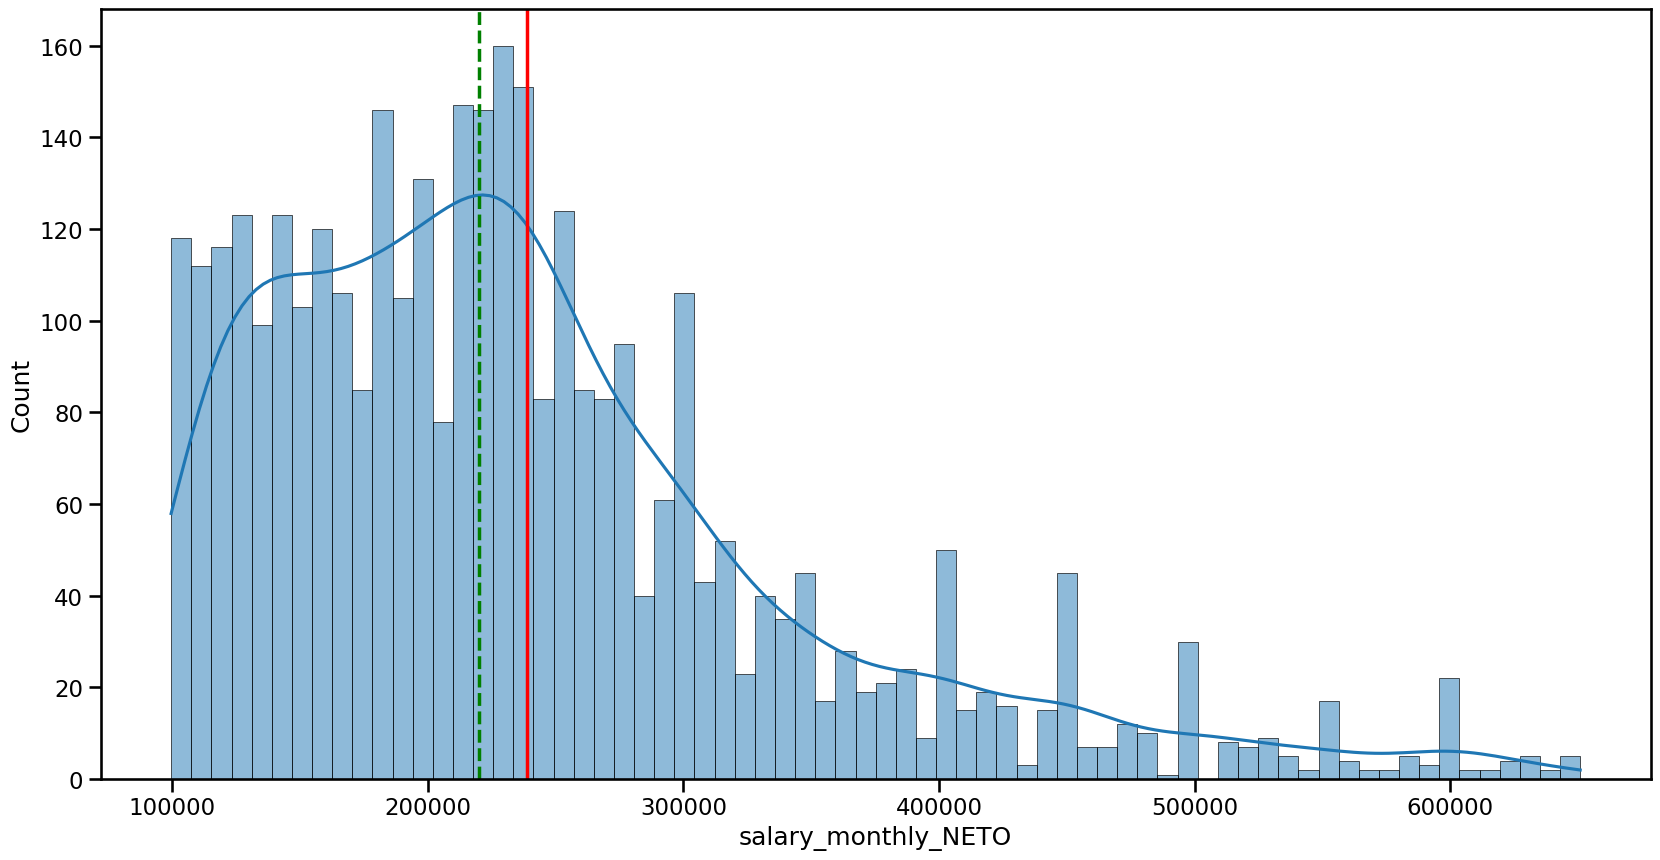

In [8]:
mean=df1['salary_monthly_NETO'].mean()
median=df1['salary_monthly_NETO'].median()
mode=df1['salary_monthly_NETO'].mode().values[0]

print(f'moda es {mode}, mediana es {median}, media es {mean}')

ax = sns.histplot(data=df1, x="salary_monthly_NETO", kde=True, bins = 70)
plt.axvline(x=median, color='g', ls='--', lw=2.5)
plt.axvline(x=mean, color='r', ls='-', lw=2.5)

ax.figure.set_size_inches(20,10)
plt.ticklabel_format(style='plain', axis='x') # axis=ejes

Podemos observar que tenemos una distribución que sigue una forma de campana típica de una distribución normal, sin embargo, se encuentra sesgada positivamente (positively skewed) lo que significa que la cola de la distribución se extiende hacia la derecha, y que la media es mayor que la mediana. 

### Conteo de frecuencias de los lenguajes de programación

La columna que contiene información sobre los lenguajes de programación utilizados es `tools_programming_languages`. Sus valores son strings con los lenguajes seleccionados separados por comas.



In [9]:
df.tools_programming_languages[:3]

0                                          Python
1    CSS, HTML, Java, Javascript, SQL, TypeScript
2                         Javascript, PHP, Python
Name: tools_programming_languages, dtype: object

Las siguientes celdas de código separan estos lenguajes de programación y cuentan la frecuencia con la que aparecen.


In [10]:
# Convert the comma-separated string of languages to a list of string.
# Remove 'ninguno de los anteriores' option, spaces and training commas.
def split_languages(languages_str):
  if not isinstance(languages_str, str):
    return []
  # Remove 'other' option
  languages_str = languages_str.lower()\
    .replace('ninguno de los anteriores', '')
  # Split string into list of items
  # Remove spaces and commas for each item
  return [lang.strip().replace(',', '')
          for lang in languages_str.split()]

# Create a new column with the list of languages
df1.loc[:, 'cured_programming_languages'] = df1.tools_programming_languages\
    .apply(split_languages)
if 'cured_programming_languages' not in relevant_columns:
    relevant_columns.append('cured_programming_languages') 

# Duplicate each row of df for each programming language
# mentioned in the response.
# We only include in df_lang the columns we are going to analyze later, so we
# don't duplicate innecesary information.
df_lang = df1.cured_programming_languages\
    .apply(pd.Series).stack()\
    .reset_index(level=-1, drop=True).to_frame()\
    .join(df1[relevant_columns])\
    .rename(columns={0: 'programming_language'})
# Horrible programming style! But a lot of data science code can be written with
# as concatenations of functions (pipelines), and there's no elegant way of
# doing that on Python.
df_lang[:5]

C:\Users\Elesefoo\AppData\Local\Temp\ipykernel_1020\4033610364.py:24: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_lang = df1.cured_programming_languages\


,programming_language,Trabajo de,tools_programming_languages,salary_monthly_BRUTO,salary_monthly_NETO,profile_years_experience,cured_programming_languages
0,python,Infosec,Python,300000.0,245000.0,10.0,[python]
2,javascript,Developer,"Javascript, PHP, Python",120000.0,115000.0,2.0,"[javascript, php, python]"
2,php,Developer,"Javascript, PHP, Python",120000.0,115000.0,2.0,"[javascript, php, python]"
2,python,Developer,"Javascript, PHP, Python",120000.0,115000.0,2.0,"[javascript, php, python]"
3,css,Developer,"CSS, HTML, Javascript",140000.0,125000.0,1.0,"[css, html, javascript]"


En la columna `programming_language` se encuentra cada lenguaje por separado. Notar que si una respuesta contenía 3 lenguajes, como `"HTML, Javascript, Python"`, la fila ha sido replicada 3 veces. Por ello, hay tres filas con índice 1.

In [11]:
df_lang.programming_language.count()

9926

In [12]:
language_count = df_lang.programming_language.value_counts()\
    .reset_index()\
    .rename(columns={'index': 'language', 'programming_language': 'frequency'})
language_count

,language,frequency
0,sql,1424
1,javascript,1375
2,html,1032
3,python,973
4,css,687
...,...,...
161,rpg400,1
162,teams,1
163,mails,1
164,usando,1


Utilizando la regla de Pareto 80/20, la cual establece que el 20% de las observaciones suelen explicar el 80% de los casos, se seleccionaron los primeros 13 lenguajes de programación que acumulan el 80% de las observaciones. Es decir, se identificó el grupo de lenguajes de programación que representan el mayor porcentaje de los casos y se seleccionó un subconjunto de ellos que explican la mayor parte de la variabilidad en los datos. 

In [13]:
lengs = sqldf("""
        SELECT language,
               frequency,
               (frequency*100/(SELECT SUM(frequency) FROM language_count)) as share
        FROM language_count
        LIMIT 11
      
      """)

lengs

,language,frequency,share
0,sql,1424,14
1,javascript,1375,13
2,html,1032,10
3,python,973,9
4,css,687,6
5,java,671,6
6,bash/shell,596,6
7,typescript,579,5
8,.net,463,4
9,php,396,3


In [14]:
leng_filter = lengs.language.unique()
filtered_df = df_lang[df_lang['programming_language'].isin(leng_filter)]
filtered_df

,programming_language,Trabajo de,tools_programming_languages,salary_monthly_BRUTO,salary_monthly_NETO,profile_years_experience,cured_programming_languages
0,python,Infosec,Python,300000.0,245000.0,10.0,[python]
2,javascript,Developer,"Javascript, PHP, Python",120000.0,115000.0,2.0,"[javascript, php, python]"
2,php,Developer,"Javascript, PHP, Python",120000.0,115000.0,2.0,"[javascript, php, python]"
2,python,Developer,"Javascript, PHP, Python",120000.0,115000.0,2.0,"[javascript, php, python]"
3,css,Developer,"CSS, HTML, Javascript",140000.0,125000.0,1.0,"[css, html, javascript]"
...,...,...,...,...,...,...,...
4155,javascript,QA / Tester,".NET, C#, Java, Javascript",300000.0,294000.0,7.0,"[.net, c#, java, javascript]"
4159,html,QA / Tester,"HTML, SQL",230000.0,190900.0,7.0,"[html, sql]"
4159,sql,QA / Tester,"HTML, SQL",230000.0,190900.0,7.0,"[html, sql]"
4160,javascript,QA / Tester,"Javascript, SQL",450989.0,297750.0,14.0,"[javascript, sql]"


Para determinar cuáles son los lenguajes de programación asociados a los mejores salarios, se nos ocurrió inicialmente comparar los salarios promedio con el salario promedio de un programador junior. De esta manera, se planteó la siguiente pregunta: ¿Cuál es el salario promedio que proporciona una mejor remuneración para un programador junior? De esta manera, se busca identificar aquellos lenguajes de programación que, en promedio, ofrecen mayores oportunidades de crecimiento y mejores salarios para aquellos que recién comienzan en el mundo de la programación.


In [15]:
order_index = filtered_df.groupby(by=["programming_language"]).agg({
    "salary_monthly_NETO": 'mean'
}).sort_values(by=['salary_monthly_NETO'], ascending=False).index

salary_per_language = filtered_df.groupby('programming_language').agg({'salary_monthly_NETO':'mean'}).round()
salary_per_language.sort_values(by = 'salary_monthly_NETO', ascending=False)

,salary_monthly_NETO
programming_language,
python,261774.0
java,257845.0
bash/shell,256195.0
.net,243649.0
javascript,239960.0
typescript,239522.0
c#,237276.0
sql,236220.0
php,235906.0


Text(0.5, 0, 'Lenguaje')

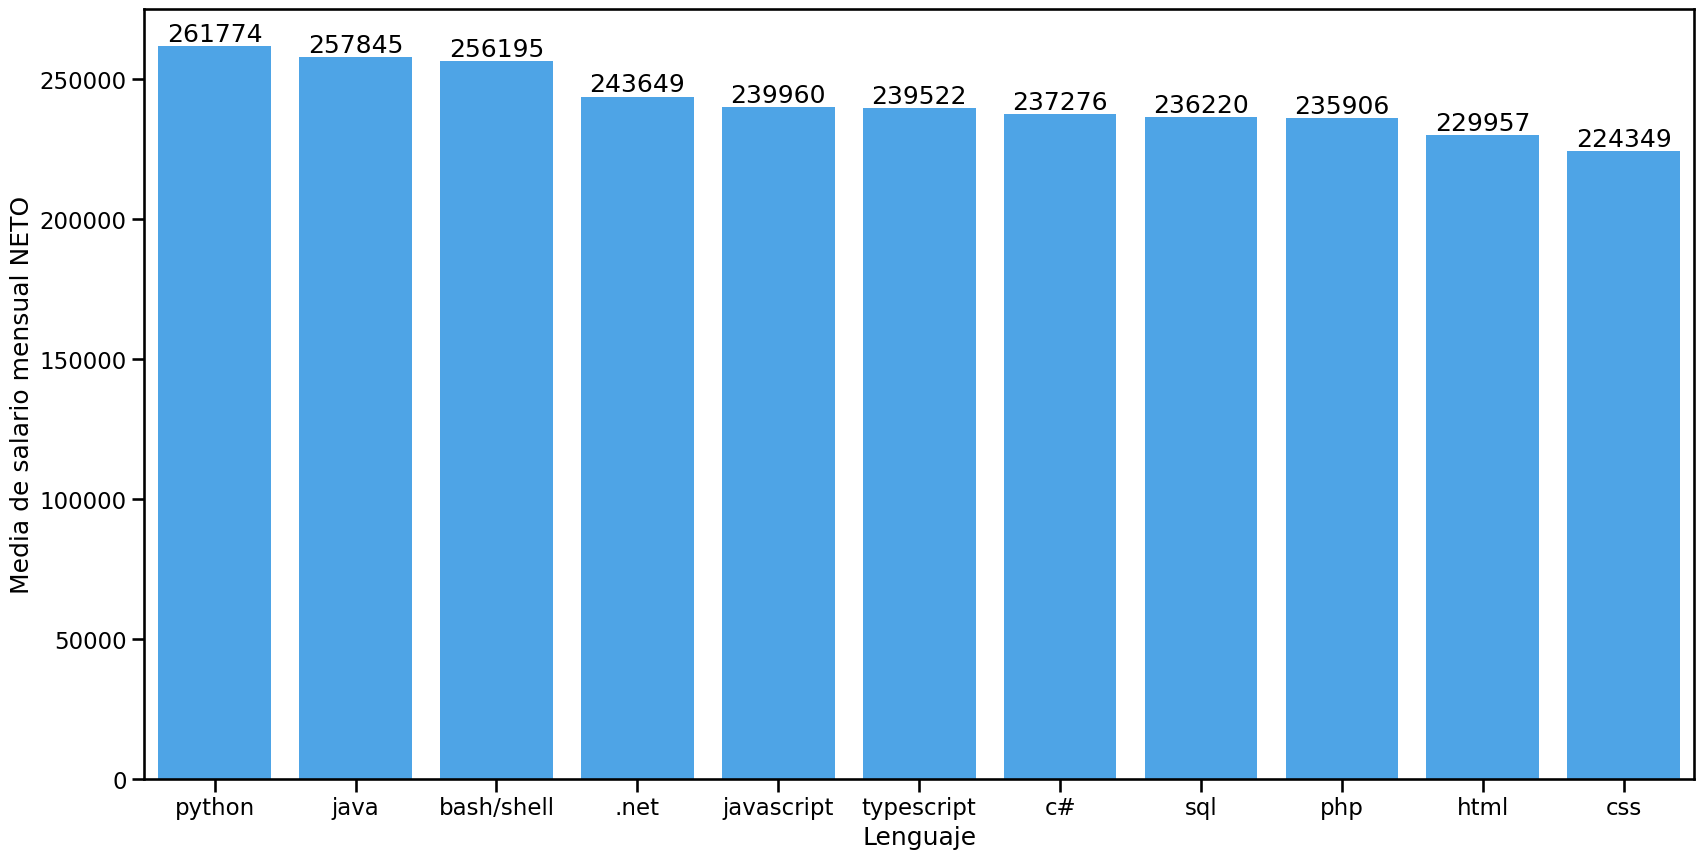

In [16]:
data1 = salary_per_language.reset_index().sort_values(by = 'salary_monthly_NETO', ascending=False)
ax = sns.barplot(data=data1, x="programming_language", y="salary_monthly_NETO", color='#35A7FF')
ax.figure.set_size_inches(20,10)
for i in ax.containers:
    ax.bar_label(i,)
ax.figure.set_size_inches(20,10)
plt.ylabel("Media de salario mensual NETO")
plt.xlabel("Lenguaje")

Text(0.5, 0, 'Lenguaje')

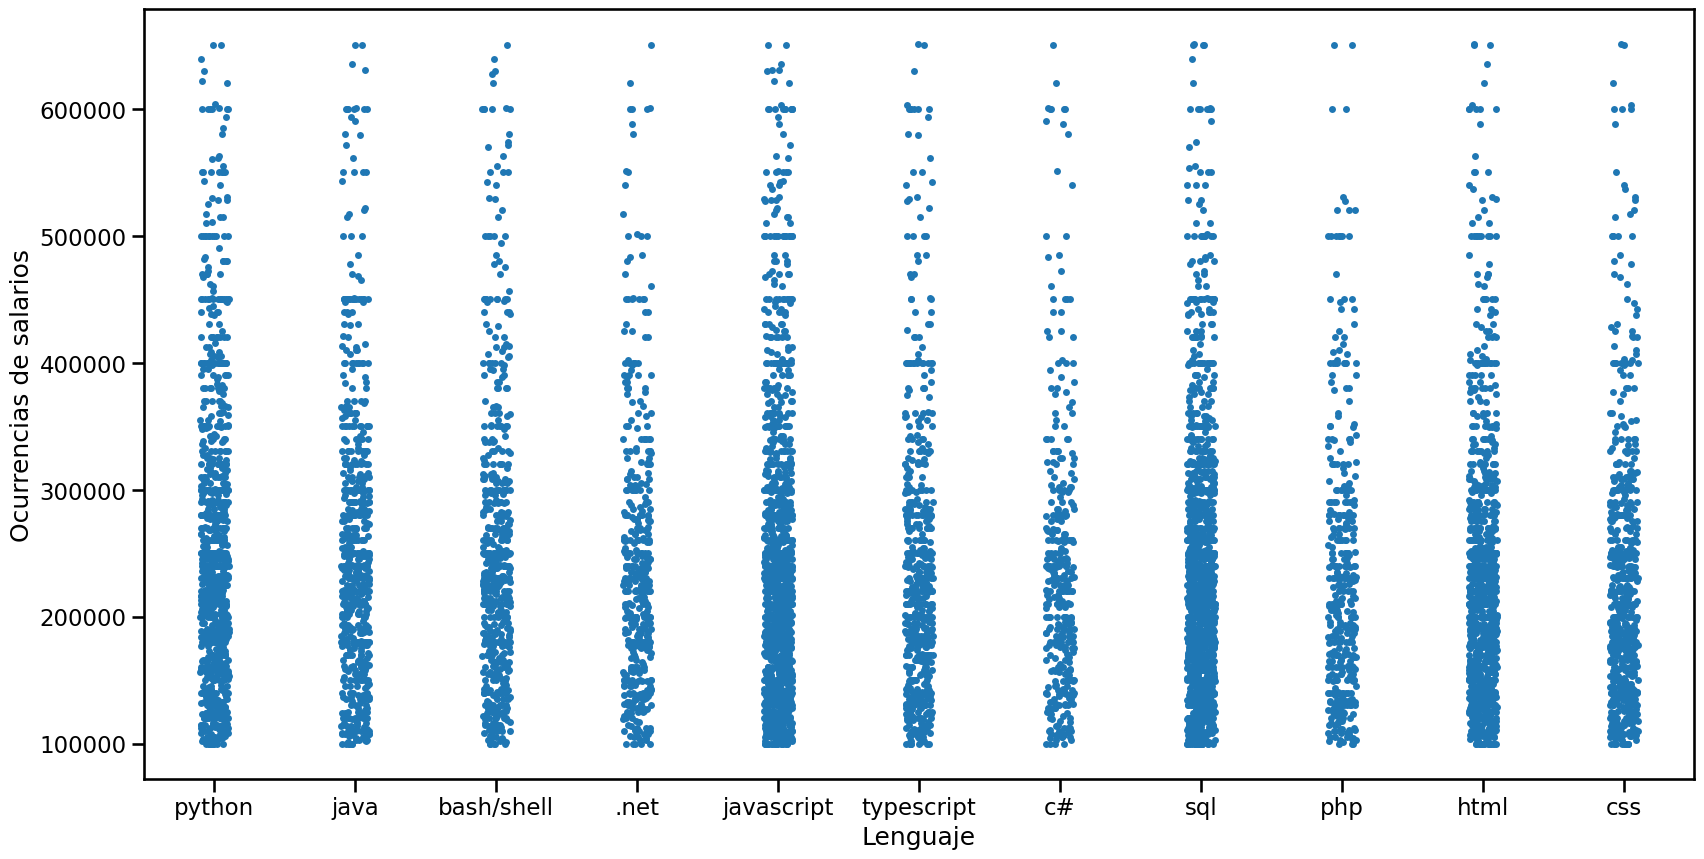

In [18]:
ax = sns.stripplot(data = filtered_df, x="programming_language", y="salary_monthly_NETO", order=order_index)
ax.figure.set_size_inches(20,10)
plt.ticklabel_format(style='plain', axis='y') # axis=ejes
plt.ylabel("Ocurrencias de salarios")
plt.xlabel("Lenguaje")

**Podemos inferir del gráfico de barras y del stripplot que:**
* Los lenguajes con mayores sueldos altos son Python, Java, Javascript.
* Vemos que Sql, Html y Css tiene los sueldos concentrados en la parte inferior. Si bien lo mismo sucede con Javascript, este ultimo tiene mas sueldos altos que los primeros. 

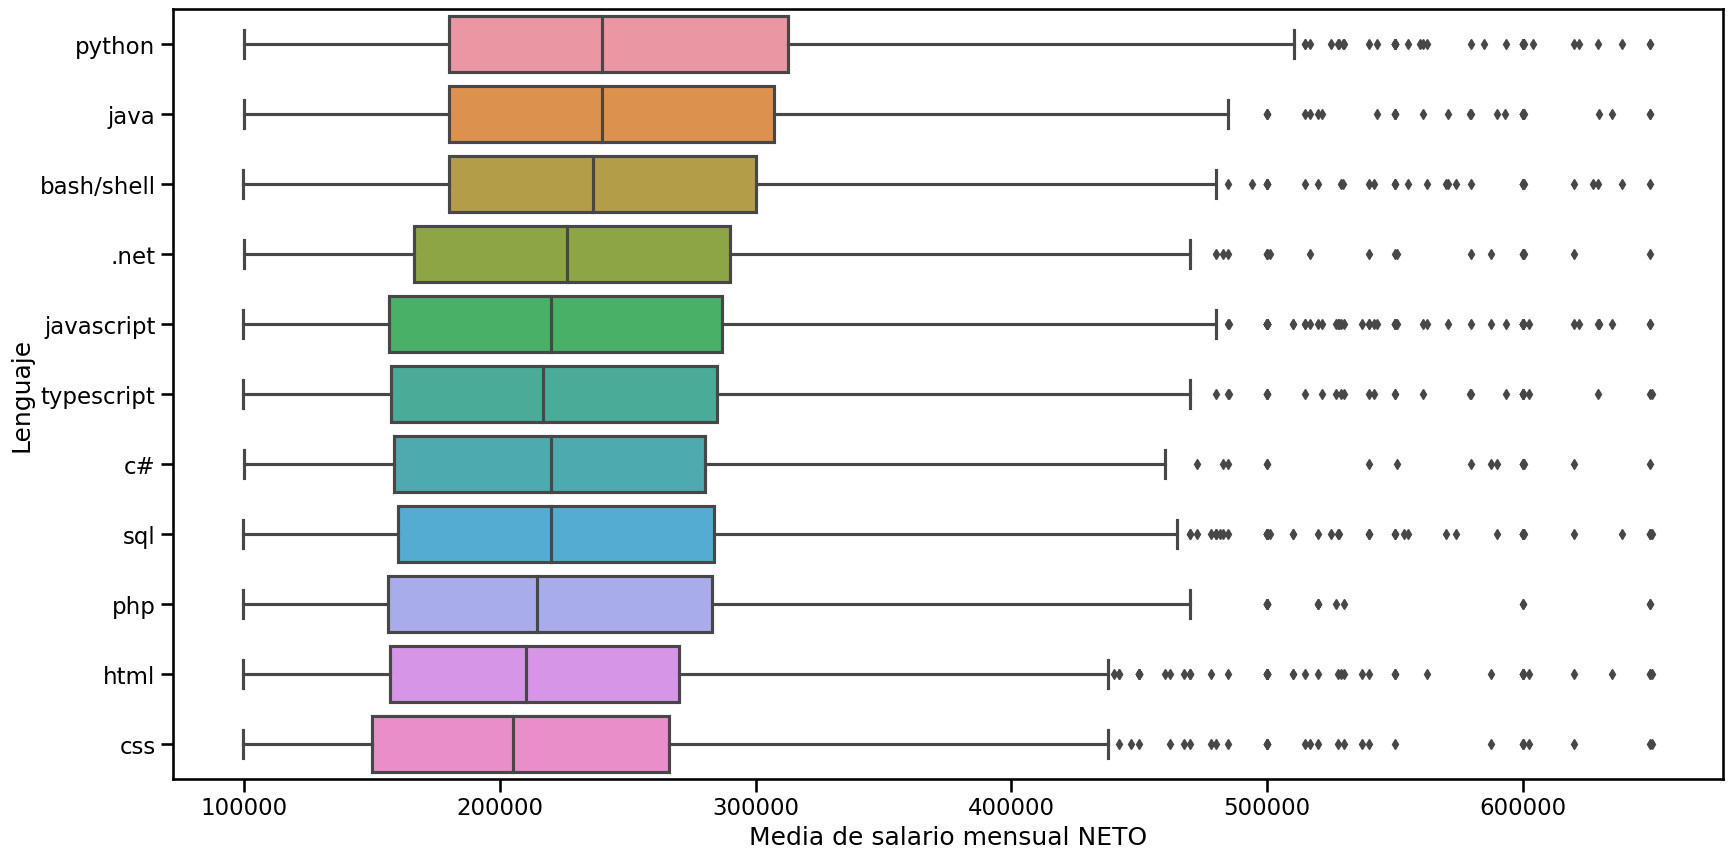

In [19]:
ax = sns.boxplot(data=filtered_df, x="salary_monthly_NETO", y="programming_language", order=order_index)
ax.figure.set_size_inches(20,10)
plt.ticklabel_format(style='plain', axis='x') # axis=ejes
plt.xlabel("Media de salario mensual NETO")
plt.ylabel("Lenguaje")
plt.show()

**Podemos inferir del boxplot que:**
* Si bien Typescript tiene una mediana de sueldos menor, vemos que los sueldos altos suele ser muy parecido con los de Java.
* JavaScript es el lenguaje con mayor cantidad de suelos mas elevados (valores atipicos)
* En la mayoria de los casos, tenemos una distribucion simetrica, pero hay algunos casos como TypeScript, Php, etc que estan sesgados, osea que hay mas dispersion de ellos.

In [20]:
filtered_df_seniority = filtered_df.copy()
filtered_df_seniority['seniority'] =  pd.cut(x=filtered_df["profile_years_experience"],bins=[-1, 2, 6, np.inf],
                                        labels=["Junior", "Semi-Senior", "Senior"])

In [21]:
salary_per_language_and_seniority = filtered_df_seniority.groupby(
                                    ['programming_language', 'seniority']).agg(
                                    {'salary_monthly_NETO':'mean'}).round().reset_index()
#salary_per_language_and_seniority

Text(0.5, 0, 'Lenguaje')

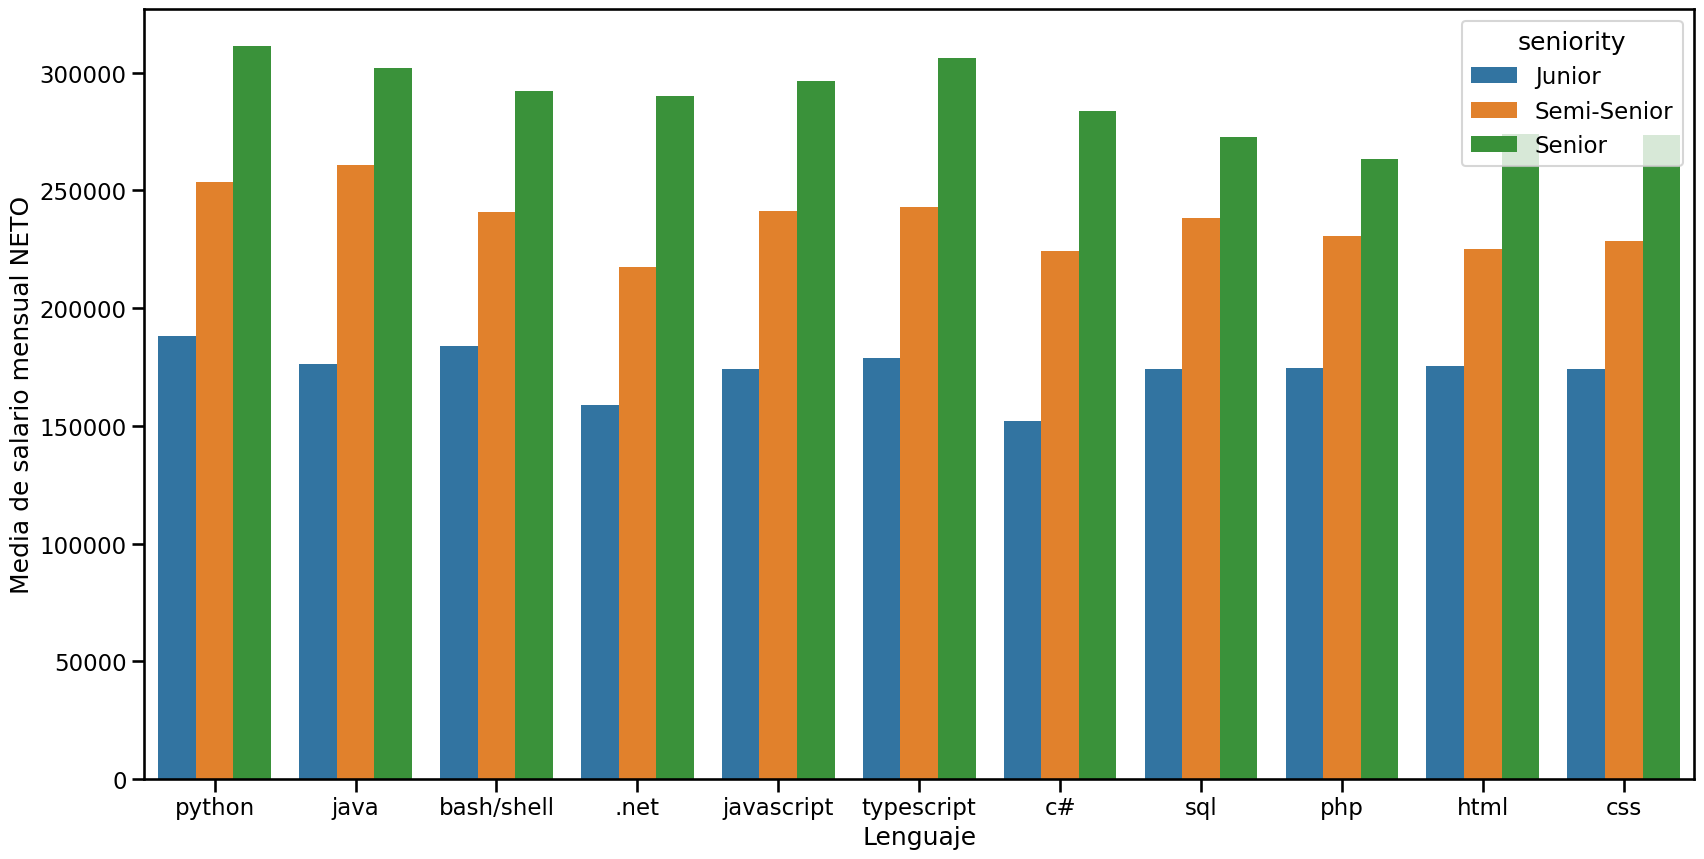

In [22]:
ax = sns.barplot(data=salary_per_language_and_seniority,
                                 x="programming_language",
                                 y="salary_monthly_NETO",
                                 hue="seniority",
                                 order=order_index)
ax.figure.set_size_inches(20,10)
plt.ylabel("Media de salario mensual NETO")
plt.xlabel("Lenguaje")

**Si diferenciamos los sueldos por exeperiencia, vemos que:**
1. Los juniors que mas ganan son los de Python y los que menos ganan son los de C#.
2. Los seniors que mas ganan, son los de Typescript
3. Podemos ver tambien que el salto salarial entre un junior y un semi-senior es grande. Mientras que de semi-senior a senior, no tan abultado.

Podemos inferir que los lenguajes de programación asociados a los mejores salarios son Python, Java y Typescript, ya que estos lenguajes presentan los sueldos más altos en promedio. Además, el nivel de experiencia también influye en los salarios, ya que los juniors que más ganan son los de Python, mientras que los seniors que más ganan son los de Typescript. Por otro lado, se observa que el salto salarial entre un junior y un semi-senior es significativo en comparación con el de un semi-senior a un senior. En cuanto a la distribución de los sueldos, la mayoría de los casos presenta una distribución simétrica, pero algunos lenguajes como TypeScript y PHP están sesgados y presentan mayor dispersión en los salarios. En resumen, para obtener los mejores salarios, es recomendable especializarse en Python, Java o Typescript y trabajar en proyectos de mayor complejidad y experiencia.

# Ejercicio 2 - Densidades y varias variables

**¿Que herramientas (prácticas y teóricas) són útiles para explorar la base, descubrir patrones, asociaciones?** <br>
Podemos utilizar diversas herramientas y técnicas para explorar una base de datos y obtener información útil de ella. En este sentido, el sentido común y el conocimiento previo de los datos son fundamentales para poder interpretar correctamente la información obtenida. Además, medidas estadísticas como la media, el máximo y el mínimo son muy útiles para entender la distribución de los datos y detectar valores atípicos que puedan afectar el análisis. Por otro lado, los distintos tipos de gráficos, como los de barras, los boxplots o los stripplots, son excelentes herramientas para visualizar la información y descubrir patrones y asociaciones entre las distintas variables. En resumen, una combinación adecuada de estas herramientas y técnicas nos permitirá obtener una visión más completa y profunda de los datos y extraer conclusiones más precisas y útiles.

In [23]:
relevant_columns = ['salary_satisfaction', 'work_years_in_company', 'profile_years_experience',
                    'profile_g', 'work_dedication', 'profile_age']

In [24]:
df.loc[:,'profile_g'] = df.profile_gender.replace({'Varón Cis': 'Varón cis',
                                                   'Mujer': 'Mujer cis',
                                                   'Mujer Cis': 'Mujer cis',
                                                   'Femenino': 'Mujer cis',
                                                   'mujer': 'Mujer cis',
                                                   'Mujer':'Mujer cis',
                                                   'Queer':'Diversidades',
                                                   'Varón Trans':'Diversidades',
                                                   'No binarie':'Diversidades',
                                                   'Mujer Trans':'Diversidades',
                                                   'Fluido':'Diversidades',
                                                   'Bigénero':'Diversidades',
                                                   'Gay':'Diversidades'}).fillna(False)

In [25]:
df_filtered = df[relevant_columns]

In [26]:
df_filtered.describe()

,salary_satisfaction,work_years_in_company,profile_years_experience,profile_age
count,5358.000000,5358.000000,5358.00000,5358.000000
mean,2.650616,2.746529,7.34316,33.279395
std,0.880582,4.491559,7.20028,7.924729
min,1.000000,0.000000,0.00000,18.000000
25%,2.000000,0.000000,2.00000,27.000000
50%,3.000000,1.000000,5.00000,32.000000
75%,3.000000,3.000000,11.00000,38.000000
max,4.000000,80.000000,45.00000,74.000000


Vemos que el valor maximo, de la columna con respecto a los años en una empresa es erroneo.

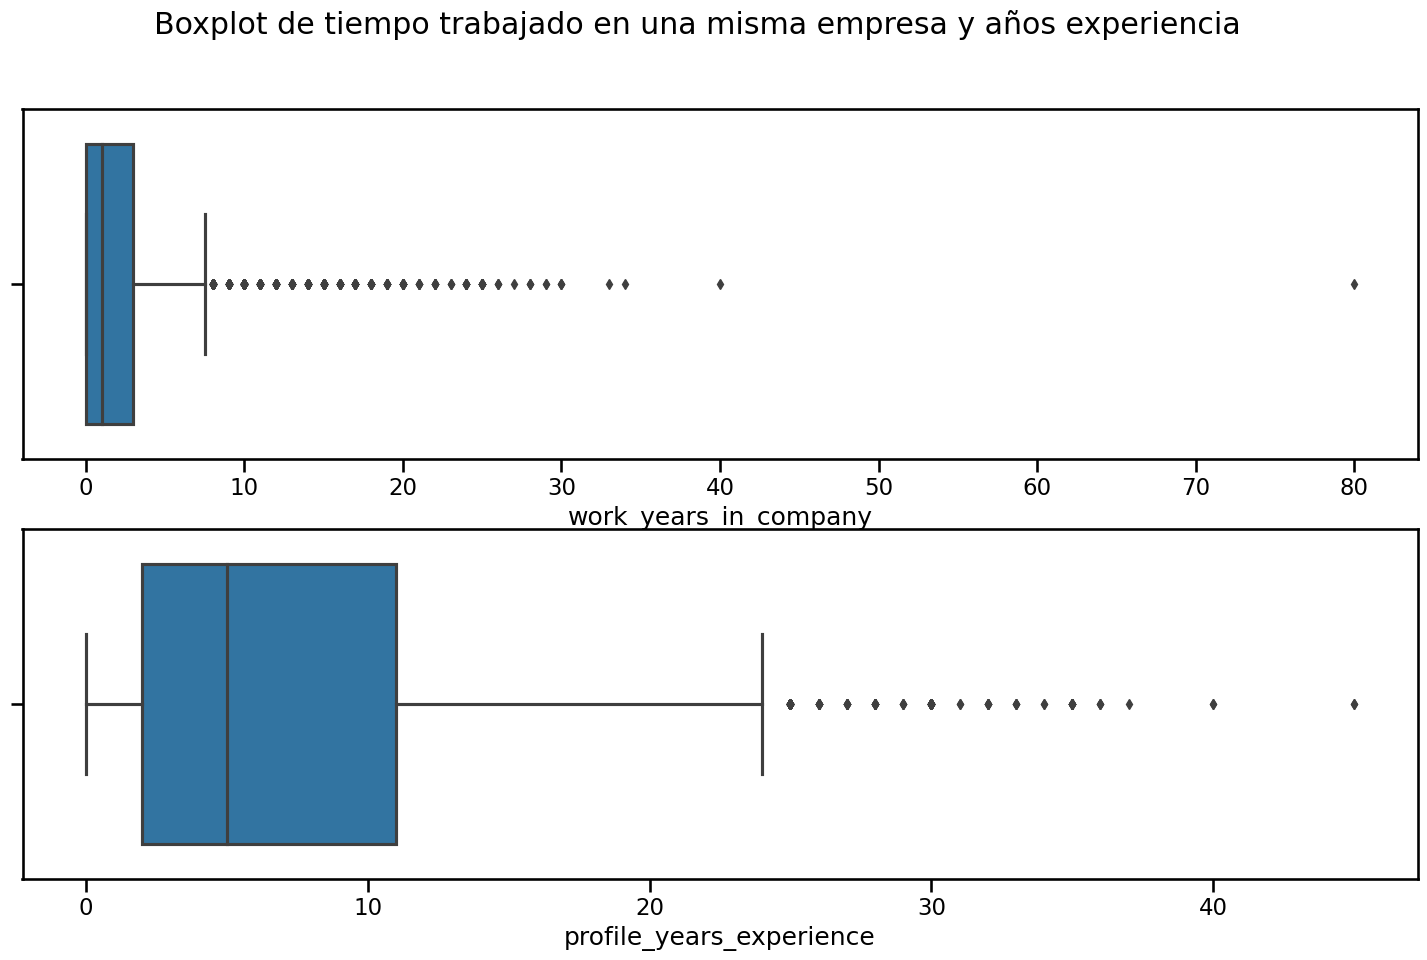

In [27]:
fig, axes = plt.subplots(2, figsize=(18, 10))
 
fig.suptitle('Boxplot de tiempo trabajado en una misma empresa y años experiencia')
 
sns.boxplot(ax=axes[0], data=df_filtered, x='work_years_in_company')
sns.boxplot(ax=axes[1], data=df_filtered, x='profile_years_experience')
plt.show()

##### Podemos ver que:
* La mayoria de personas tiene menos de 40 años de experienca y de trabajo en una misma empresa
* La mayoria tiene pocos años de experencia y que hay mucha dispersion entre los primeros 10 años.

Revisemos datos extremos y erroneos:

Ademas de la informacion obtenida del box plot. Observemos cuantas entradas tiene mas años en una misma empresa que años de experencia.

In [28]:
df_filtered.describe()

,salary_satisfaction,work_years_in_company,profile_years_experience,profile_age
count,5358.000000,5358.000000,5358.00000,5358.000000
mean,2.650616,2.746529,7.34316,33.279395
std,0.880582,4.491559,7.20028,7.924729
min,1.000000,0.000000,0.00000,18.000000
25%,2.000000,0.000000,2.00000,27.000000
50%,3.000000,1.000000,5.00000,32.000000
75%,3.000000,3.000000,11.00000,38.000000
max,4.000000,80.000000,45.00000,74.000000


In [29]:
wrong_data = df_filtered[df_filtered['work_years_in_company'] > df['profile_years_experience']]
wrong_data

,salary_satisfaction,work_years_in_company,profile_years_experience,profile_g,work_dedication,profile_age
11,2,30.0,25.0,Varón cis,Full-Time,56
23,2,3.0,0.0,Varón cis,Full-Time,33
62,1,12.0,5.0,Varón cis,Full-Time,43
68,2,9.0,2.0,Varón cis,Full-Time,33
128,3,3.0,2.0,Varón cis,Full-Time,27
...,...,...,...,...,...,...
5294,3,7.0,5.0,Varón cis,Full-Time,30
5315,1,5.0,0.0,Varón cis,Full-Time,26
5316,2,5.0,2.0,Varón cis,Full-Time,32
5330,1,10.0,0.0,Varón cis,Full-Time,31


Como minimo, se tiene que tener la misma cantidad de años trabajados en una misma empresa que años de experencia. Eliminaremos todas estas filas por ser erroneas.

In [30]:
df_filtered_years = df_filtered.copy()
df_filtered_years.drop(wrong_data.index, axis=0,inplace=True)# Podemos usar los mismos index ya que es un pedazo del mismo df.
df_filtered_years.describe()

,salary_satisfaction,work_years_in_company,profile_years_experience,profile_age
count,5115.000000,5115.000000,5115.000000,5115.000000
mean,2.668817,2.418612,7.463177,33.157185
std,0.880965,3.934323,7.244046,7.898526
min,1.000000,0.000000,0.000000,18.000000
25%,2.000000,0.000000,2.000000,27.000000
50%,3.000000,1.000000,5.000000,32.000000
75%,3.000000,3.000000,11.000000,38.000000
max,4.000000,40.000000,45.000000,74.000000


In [31]:
df_filtered_years[df_filtered_years['work_years_in_company']==40]

,salary_satisfaction,work_years_in_company,profile_years_experience,profile_g,work_dedication,profile_age
2518,2,40.0,40.0,Mujer cis,Full-Time,66


Veamos la columna salary_satisfaction:

In [32]:
df_filtered_years.salary_satisfaction.unique()

array([2, 4, 1, 3], dtype=int64)

In [33]:
df_filtered_years.work_dedication.unique()

array(['Full-Time', 'Part-Time'], dtype=object)

<Axes: xlabel='salary_satisfaction'>

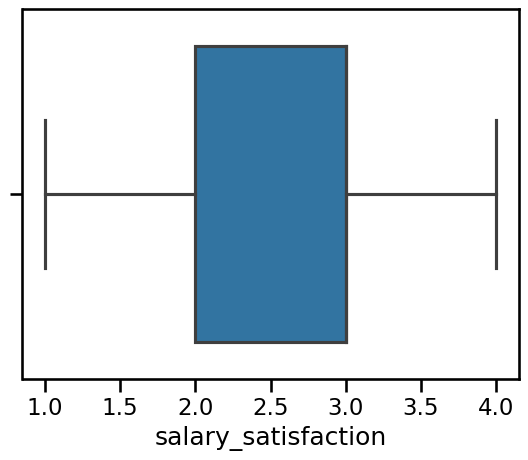

In [34]:
sns.boxplot(data=df_filtered_years, x='salary_satisfaction')

columnas profile_age y work_dedication:

In [35]:
df_filtered_years.profile_age.describe()

count    5115.000000
mean       33.157185
std         7.898526
min        18.000000
25%        27.000000
50%        32.000000
75%        38.000000
max        74.000000
Name: profile_age, dtype: float64

In [36]:
df_filtered_years.work_dedication.unique()

array(['Full-Time', 'Part-Time'], dtype=object)

No tenemos datos extremos ni erroneos en ninguna de las dos columnas.

## a) Densidad conjunta

Que herramientas visuales y modelos puede utilizar para estudiar la distribución y comportamiento de sus datos? 

Elija tres variables numéricas y 2 variables categóricas. Visualice la base según varias de las variables elegidas. Puede describir de alguna forma el comportamiento de sus datos? Que herramientas utilizaría? Describa


**Para variables categoricas tenemos:**
1. Graficos de barras
2. Graficos torta
3. Tree maps
4. Sankey

**Para variables numericas tenemos:**
1. Graficos de cajas
2. Histogramas
3. Covarianza
4. Matriz correlacion
5. Graficos de dispersion.
6. Mapas de calor
7. Graficos de lineas

## Seleccionamos las variables:

### <u>Variables numericas:</u>
1. salary_satisfaction
2. work_years_in_company
3. profile_age

### <u>Variables categoricas:</u>
1. profile_gender
2. work_dedication

# <p style="text-align: center;"><u>Satisfaccion del salario en relacion a los años de trabajo:</u></p>

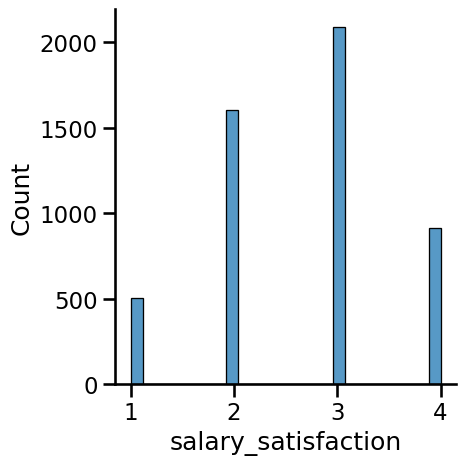

In [37]:
sns.displot(data = df_filtered_years , x = "salary_satisfaction")

### A simple vista se puede ver que la mayoria tiene una buena satisfaccion con respecto a su salario.

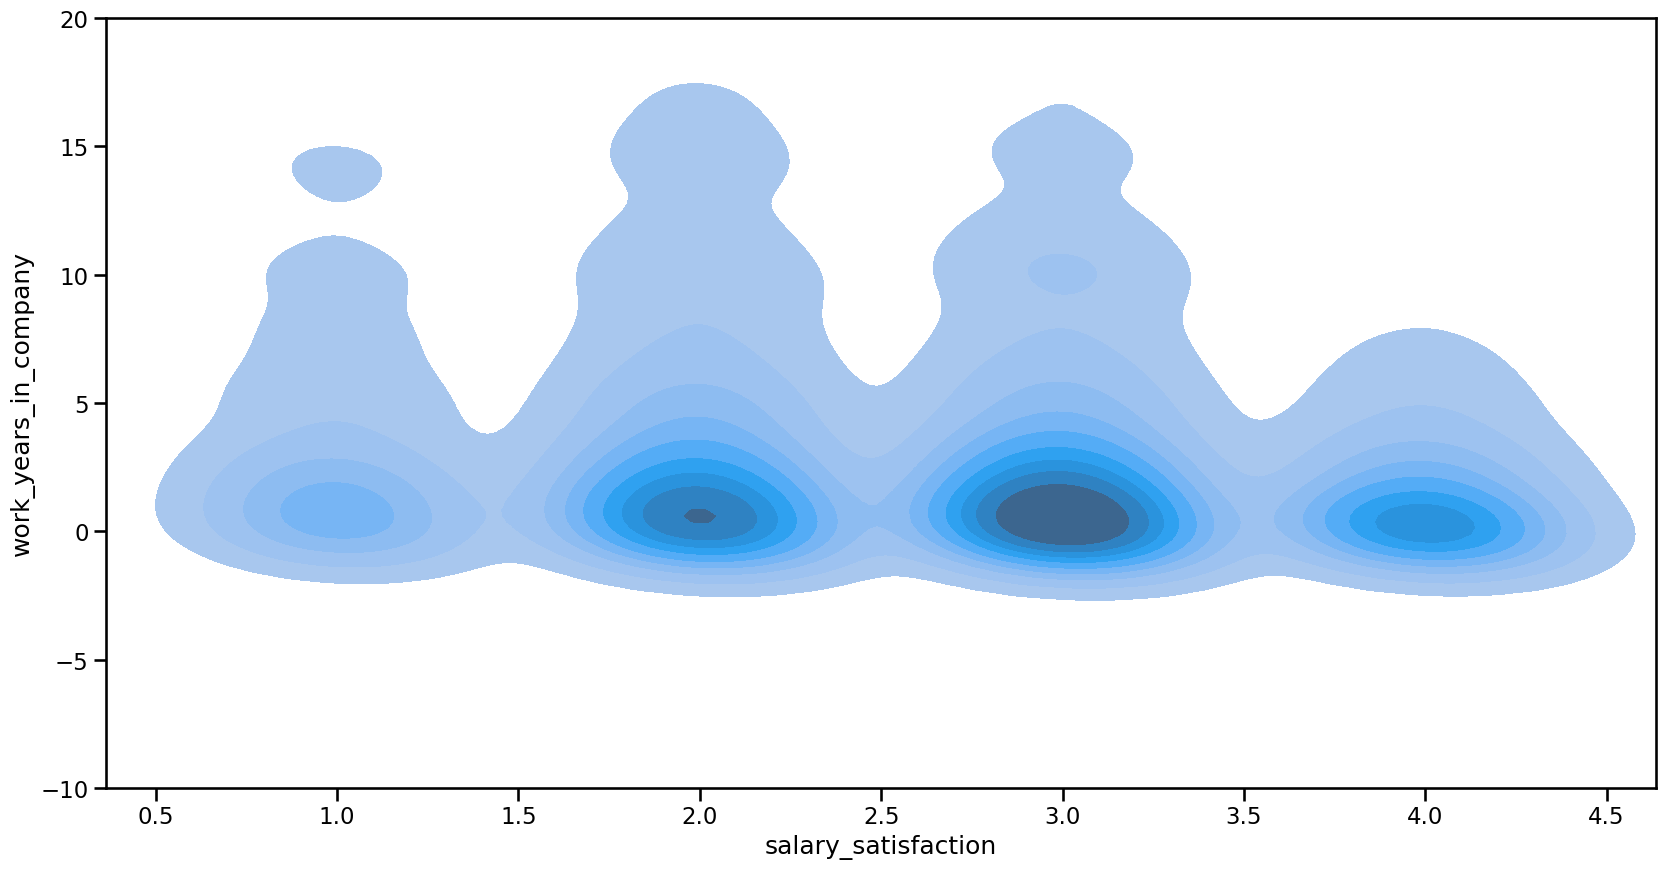

In [38]:
ax = sns.kdeplot(data = df_filtered_years, x = "salary_satisfaction", y = "work_years_in_company", fill = True)
#ax.set(yticks=range(0, 40))#, 2))
ax.set_ylim(-10,20)
ax.figure.set_size_inches(20,10)

In [39]:
few_years = df_filtered_years[df_filtered_years['work_years_in_company'] <= 5]
medium_years = df_filtered_years[(df_filtered_years['work_years_in_company'] > 5) & (df_filtered_years['work_years_in_company']<=10)]
lot_of_years = df_filtered_years[df_filtered_years['work_years_in_company'] >= 10]
#medium_years.groupby(["salary_satisfaction", 'work_years_in_company']).agg(salary_satisfaction_count = (
#                                                                            'salary_satisfaction', 'count'))

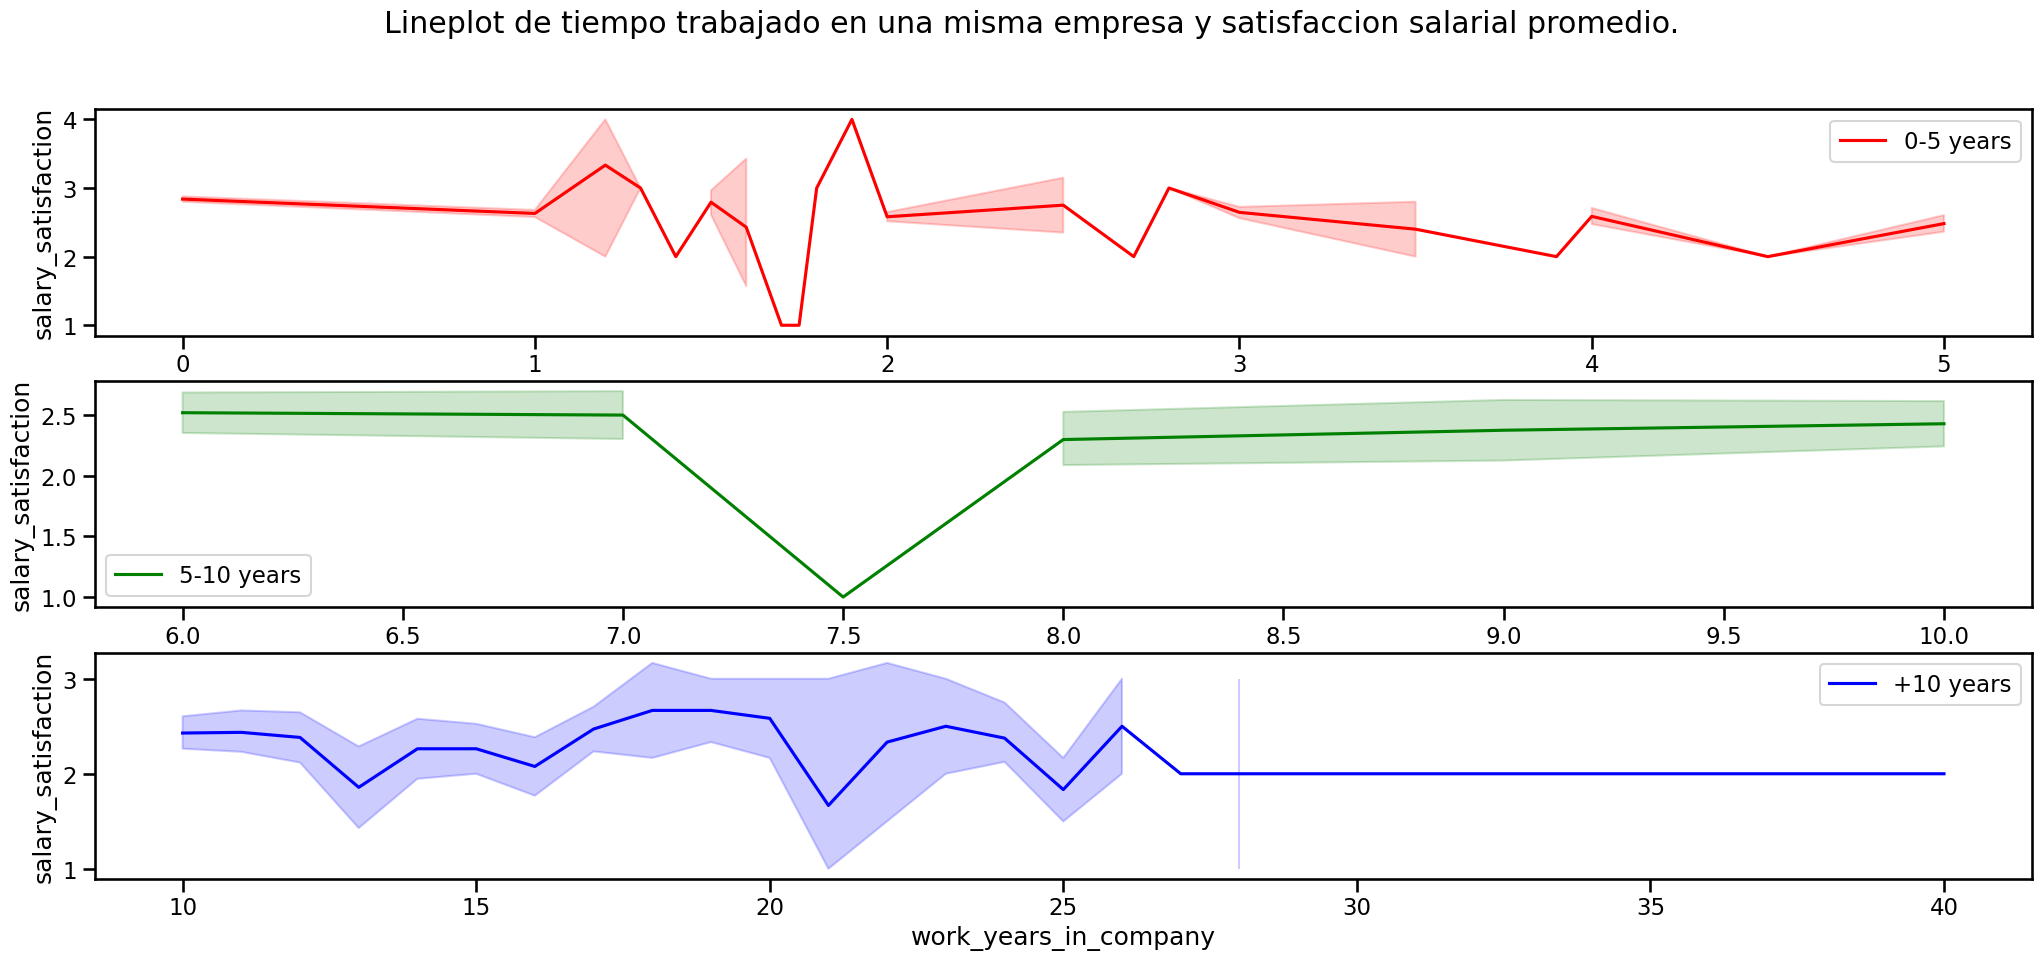

In [40]:
fig, axes = plt.subplots(3, figsize=(25, 10))
 
fig.suptitle('Lineplot de tiempo trabajado en una misma empresa y satisfaccion salarial promedio.')

ax = sns.lineplot(ax=axes[0], data=few_years, x='work_years_in_company', y='salary_satisfaction', color = 'r')
ax.legend(['0-5 years'])
ax = sns.lineplot(ax=axes[1], data=medium_years, x='work_years_in_company', y='salary_satisfaction', color='g')
ax.legend(['5-10 years'])
ax = sns.lineplot(ax=axes[2], data=lot_of_years, x='work_years_in_company', y='salary_satisfaction', color='b')
ax.legend(['+10 years'])

plt.show()

**<h3><u>Podemos decir que:</u></h3>**
* Podemos ver que aquellos que transcurren sus primeros años en las empresas, tiene una alta satisfaccion con respecto al salario.
* En general, la mayoria de las personas tienen una buena satisfaccion con respecto al salario.
* Los que tiene mas de 10 años en la empresa, suelen tener buena satisfaccion con respecto a los salarios, aunque tiene mas variablidad que los que tiene poco tiempo.
* Los que mejor satisfaccion salarial tiene, son aquellos que estan entre 5 y 10 años de antiguedad.

# <p style="text-align: center;"><u>Satisfaccion en relacion a la edad:</u></p>

#### Veamos por grupos de edades:

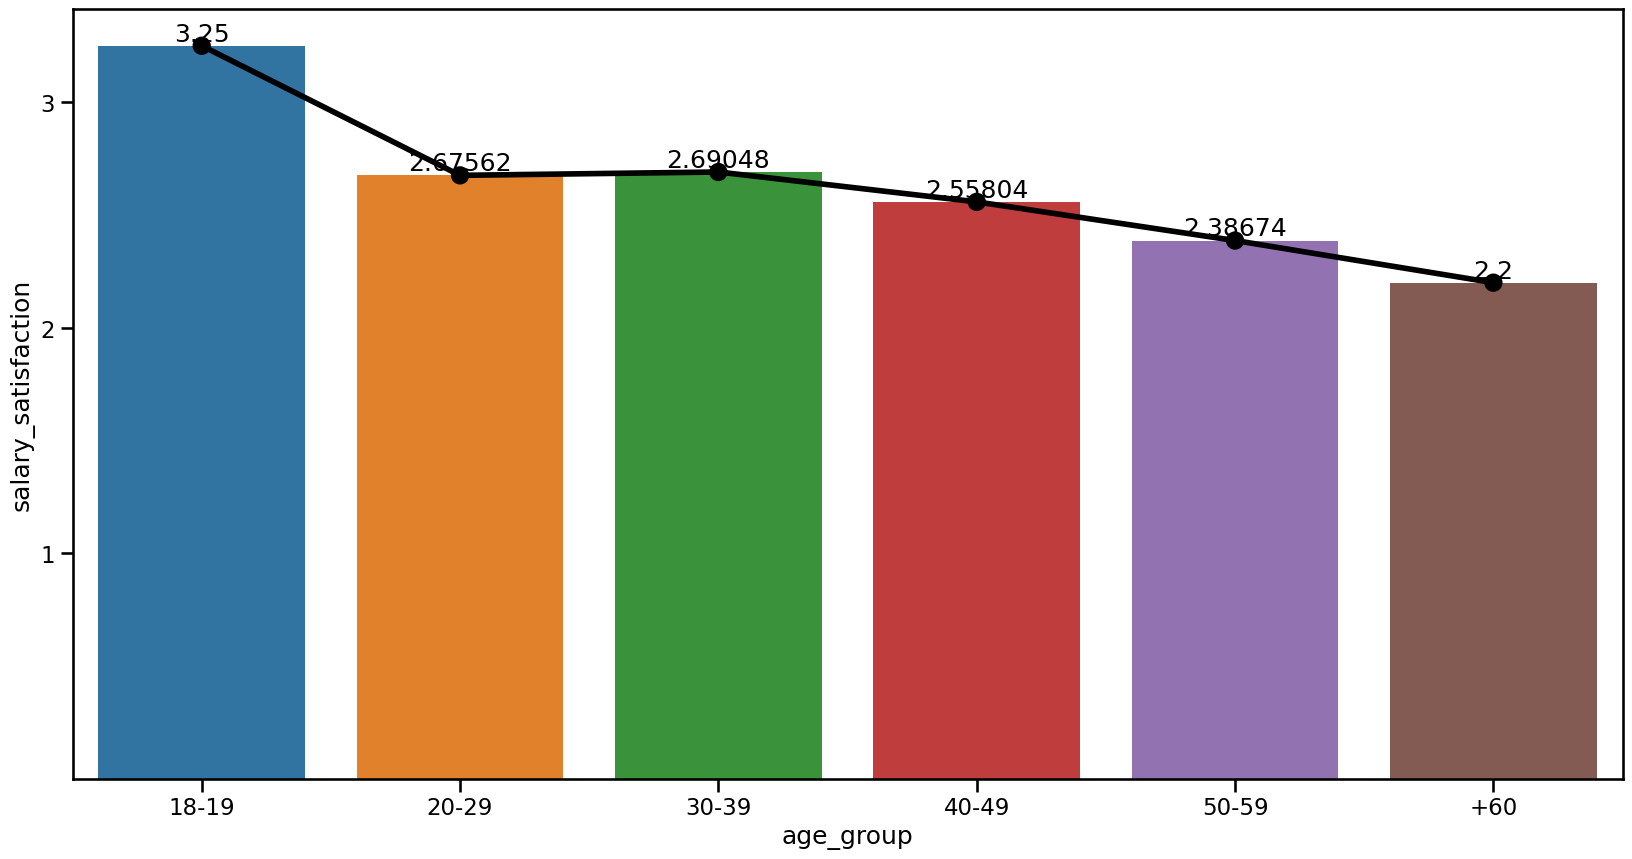

In [41]:
filtered_df_age_groups = df_filtered.copy()
filtered_df_age_groups['age_group'] =  pd.cut(x=df_filtered["profile_age"],
                                              bins=[15, 19, 29, 39, 49, 59, 67],
                                        labels=['18-19', '20-29', '30-39', '40-49', '50-59', '+60'])
ax = sns.barplot(filtered_df_age_groups, x = 'age_group', y='salary_satisfaction', errorbar=None)
for i in ax.containers:
    ax.bar_label(i,)
plt.yticks([1, 2, 3, 4])

sns.pointplot(filtered_df_age_groups, x = 'age_group', y='salary_satisfaction', errorbar=None, ax=ax, color='black')
ax.figure.set_size_inches(20,10)



Al analizar la relación entre la edad y la satisfacción salarial, podemos concluir que en general, las personas menores de 45 años presentan niveles similares de satisfacción salarial. Además, al observar el gráfico de rangos de edad, se puede apreciar una ligera disminución en la satisfacción salarial a medida que aumenta la edad, aunque esta disminución es poco significativa.

Por otro lado, es interesante notar que las edades que presentan mayor variabilidad en la satisfacción salarial son las mayores de 60 años. Esto podría deberse a factores como la jubilación, la experiencia laboral y la remuneración por antigüedad, entre otros. En conclusión, aunque en general la edad no parece ser un factor determinante en la satisfacción salarial, es importante considerar las variaciones y patrones que puedan presentarse en determinados grupos etarios para tener una comprensión más completa de la situación.

# <p style="text-align: center;"><u> Satisfaccion en relacion a la identidad sexual:</u></p>

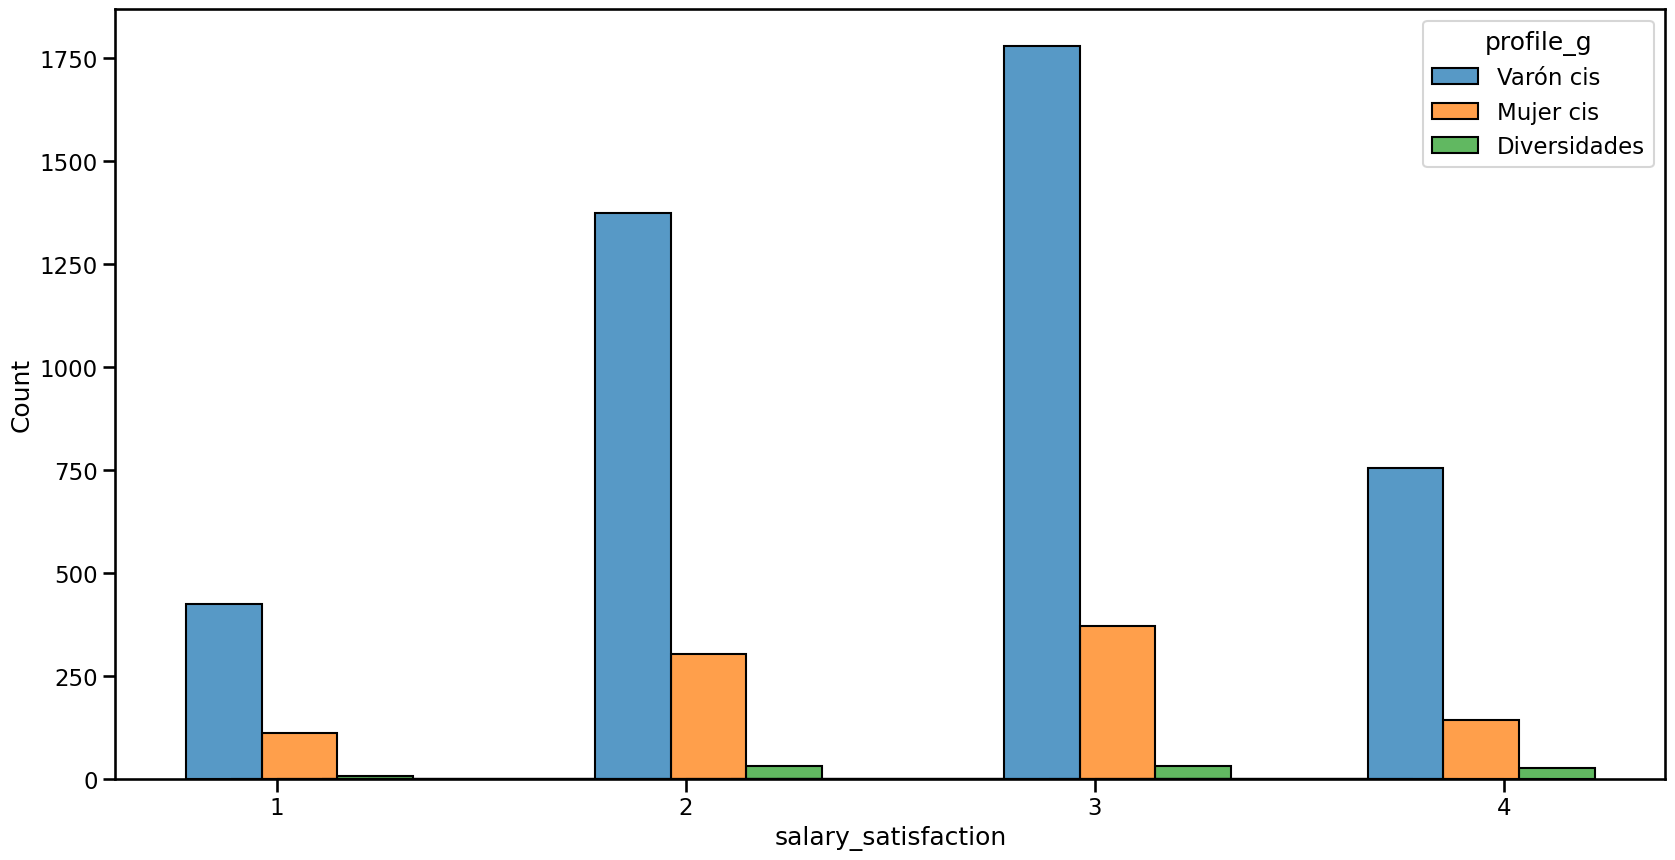

In [42]:
ax = sns.histplot(df, x='salary_satisfaction', hue='profile_g', multiple="dodge",shrink=5)
ax.figure.set_size_inches(20,10)
plt.xticks([1, 2, 3, 4])
plt.show()

In [43]:
only_men = df[df['profile_g']=='Varón cis']
only_woman = df[df['profile_g']=='Mujer cis']
only_diversidades = df[df['profile_g']=='Diversidades']

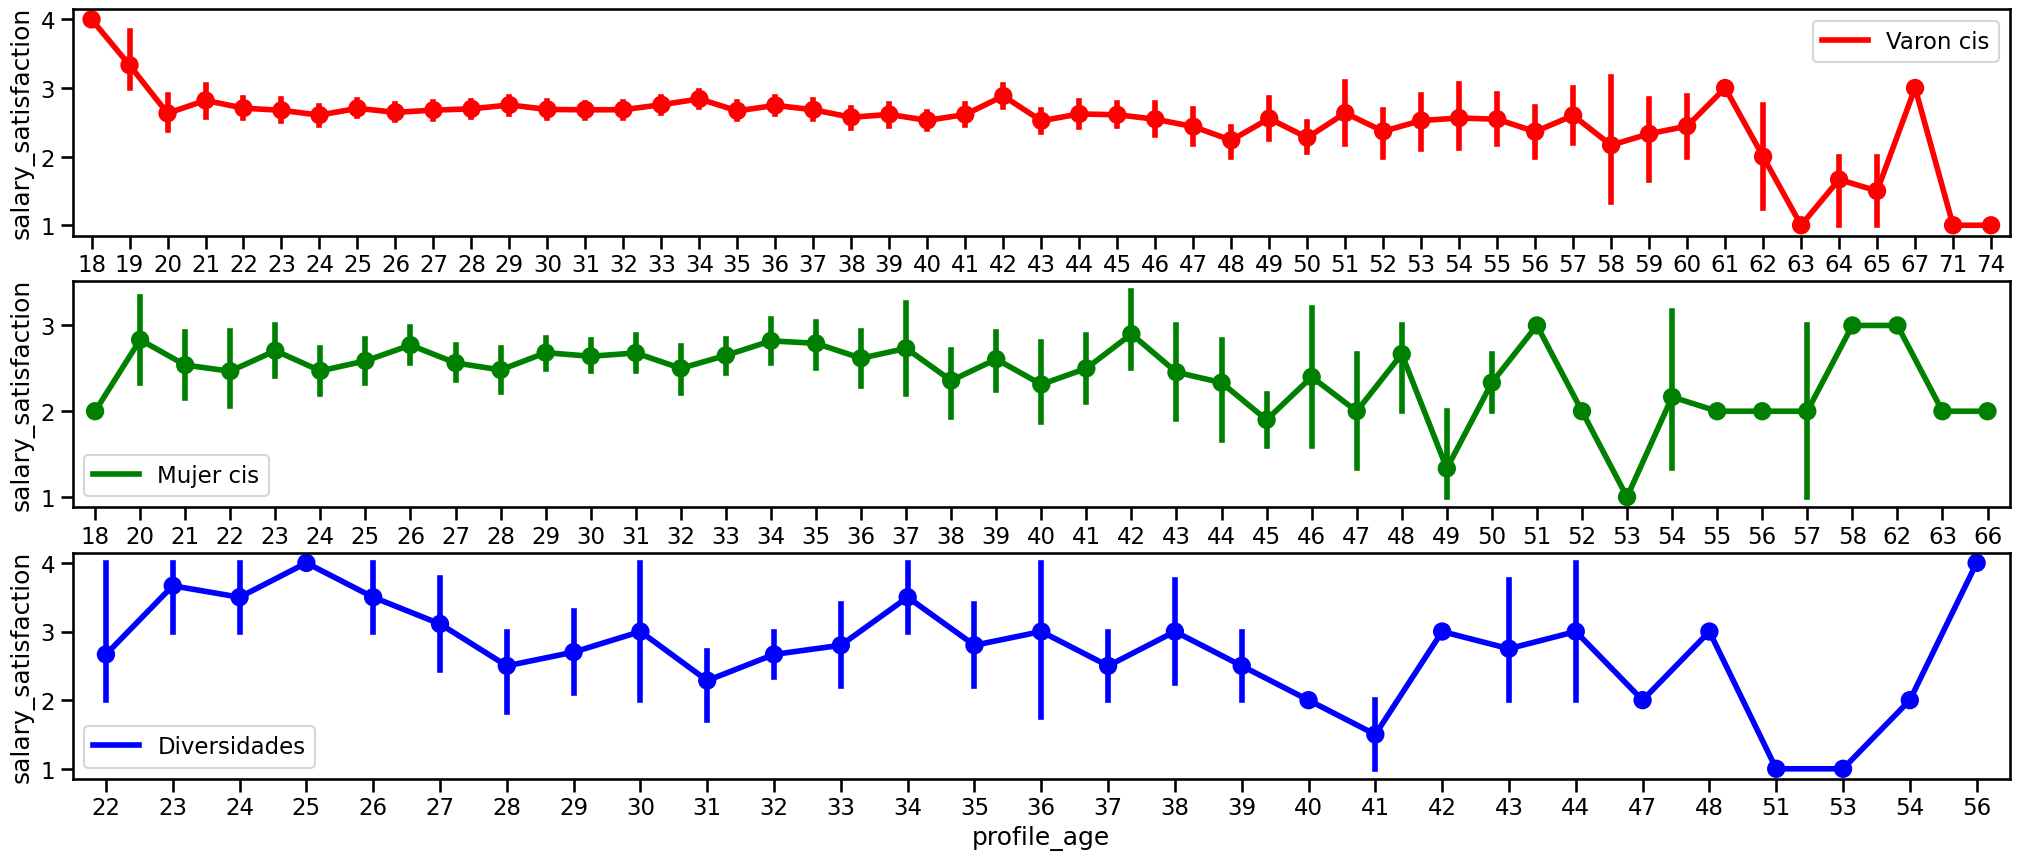

In [44]:
fig, axes = plt.subplots(3, figsize=(25, 10))
ax = sns.pointplot(ax=axes[0], data=only_men, x = 'profile_age', y='salary_satisfaction', color = 'r')
ax.legend(['Varon cis'])
ax = sns.pointplot(ax=axes[1], data=only_woman, x = 'profile_age', y='salary_satisfaction', color='g')
ax.legend(['Mujer cis'])
ax = sns.pointplot(ax=axes[2], data=only_diversidades, x = 'profile_age', y='salary_satisfaction', color='b')
ax.legend(['Diversidades'])

plt.show()

In [45]:
df.columns

Index(['work_country', 'work_province', 'work_dedication',
       'work_contract_type', 'salary_monthly_BRUTO', 'salary_monthly_NETO',
       'numero', 'salary_in_usd', 'salary_last_dollar_value',
       'salary_pay_cripto', 'salary_%_cripto', 'salary_has_bonus',
       'salary_bonus_tied_to', 'salary_inflation_adjustment',
       'salary_percentage_inflation_adjustment',
       'salary_month_last_inflation_adjustment',
       'salary_comparison_last_semester', 'salary_benefit',
       'salary_satisfaction', 'Trabajo de', 'profile_years_experience',
       'work_years_in_company', 'work_years_in_current_position',
       'work_people_in_charge_of', 'tools_platform',
       'tools_programming_languages', 'tools_frameworks', 'tools_data_bases',
       'tools_qa_testing', 'company_employee_number', 'work_work_modality',
       'Si trabajas bajo un esquema híbrido ¿Cuántos días a la semana vas a la oficina?',
       'company_recommended', 'profile_studies_level',
       'profile_studies_le

In [46]:
df.work_work_modality.unique()

array(['100% remoto', 'Híbrido (presencial y remoto)', '100% presencial'],
      dtype=object)

In [47]:
df.work_dedication.unique()

array(['Full-Time', 'Part-Time'], dtype=object)

No vemos a partir de este análisis una diferencia significativa entre la satisfacción de salario en relación al género. 

## b) Asociación

* Necesitamos decidir si sacar o no la columna de salario bruto. Para hacer la encuesta más simple.
¿Existe una correlación entre el salario bruto y el neto? Que abordaje y medidas usaría



Podemos calcular la correlación que existe entre las variables, ya sea con un mapa de calor para ver si la correlación es importante comparada a la correlación de las otras variables, o también calculando la correlación individual entre las dos columnas y ver qué tan cercana a 1 (o -1) es. 


In [48]:
df = df[(df['salary_monthly_NETO'] >= 80000) & (df['salary_monthly_NETO']<=850000)]

In [49]:
col_interes = ['salary_monthly_BRUTO','salary_monthly_NETO','profile_years_experience','work_years_in_company','work_years_in_current_position','work_people_in_charge_of','profile_age']
df[col_interes].dropna().corr()

,salary_monthly_BRUTO,salary_monthly_NETO,profile_years_experience,work_years_in_company,work_years_in_current_position,work_people_in_charge_of,profile_age
salary_monthly_BRUTO,1.000000,0.817920,0.294686,0.053508,0.042350,0.165015,0.185272
salary_monthly_NETO,0.817920,1.000000,0.277954,0.037230,0.042649,0.142583,0.171022
profile_years_experience,0.294686,0.277954,1.000000,0.482416,0.461643,0.207658,0.739138
work_years_in_company,0.053508,0.037230,0.482416,1.000000,0.662108,0.165778,0.422703
work_years_in_current_position,0.042350,0.042649,0.461643,0.662108,1.000000,0.066566,0.370427
work_people_in_charge_of,0.165015,0.142583,0.207658,0.165778,0.066566,1.000000,0.175407
profile_age,0.185272,0.171022,0.739138,0.422703,0.370427,0.175407,1.000000


Vemos una alta correlación (0.82) entre las columnas de salario bruto y neto. Veamoslo gráficamente.


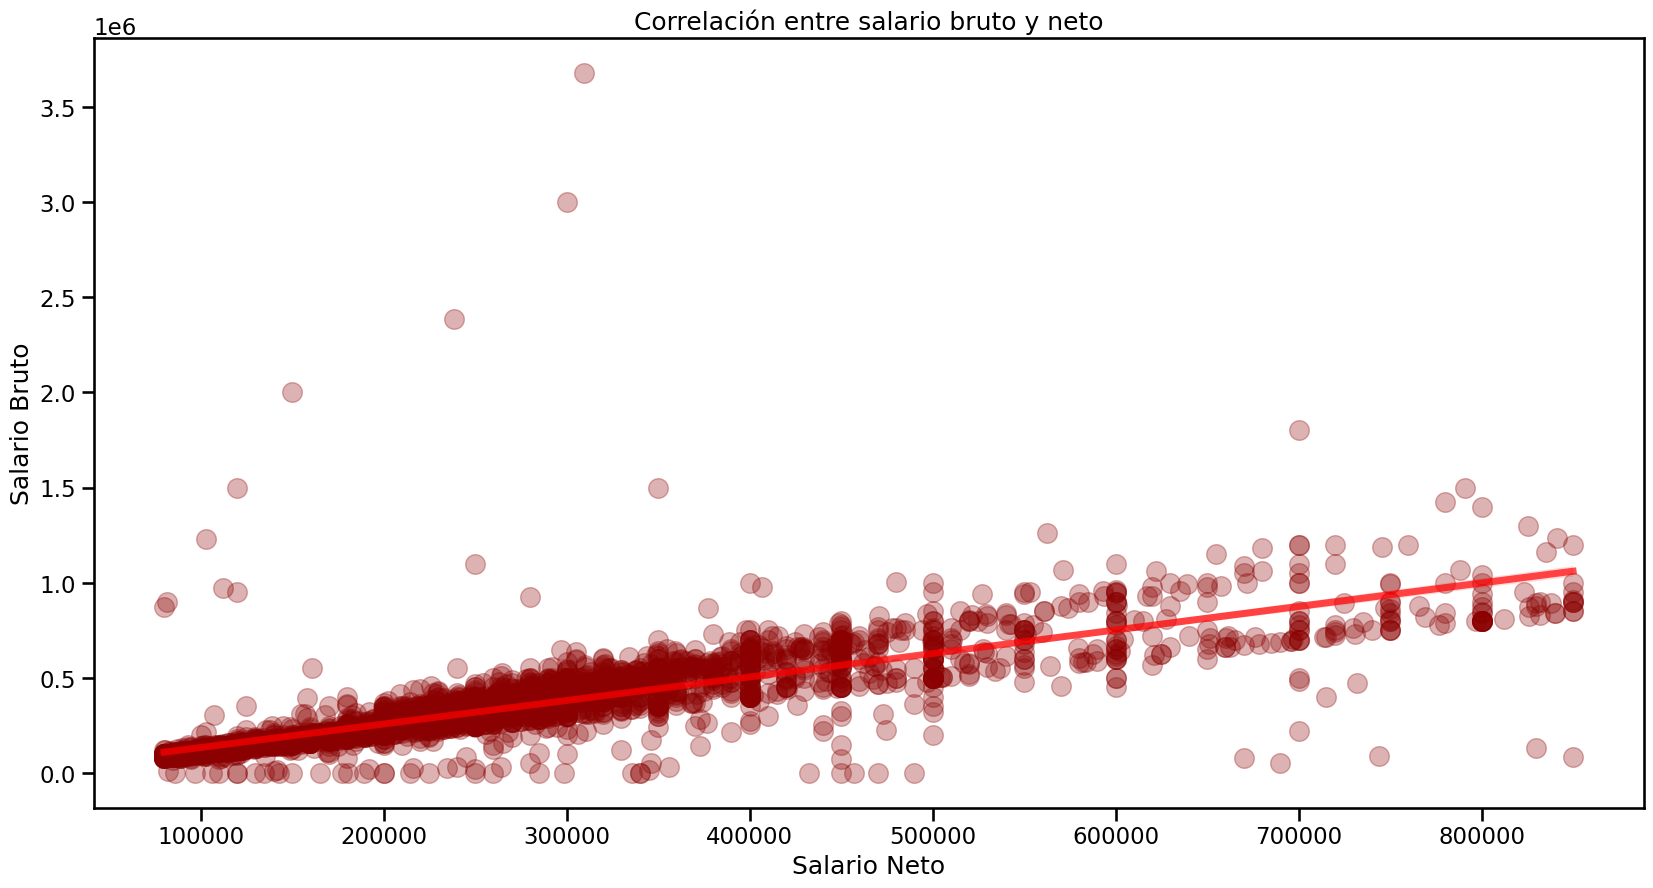

In [87]:
x = df["salary_monthly_NETO"]
y = df["salary_monthly_BRUTO"]

ax = sns.regplot(x=x, y=y, line_kws={"color":"r","alpha":0.7,"lw":5}, scatter_kws={"color":"darkred","alpha":0.3,"s":200})
plt.xlabel("Salario Neto")
plt.ylabel("Salario Bruto")
plt.title("Correlación entre salario bruto y neto")
ax.figure.set_size_inches(20,10)
plt.show()

Gráficamente replicamos lo obtenido en nuestra matriz de correlación, pero vayamos más allá. Sabemos que la relación entre ambas columnas debería ser más o menos de un 20%, para el caso general. Es decir, el salario bruto debería ser un 20% más alto que el neto en el caso promedio. Veamos si realmente se da esta relación con nuestros datos. 

In [51]:
# Calcular la proporción entre salario neto y bruto
proporcion = df["salary_monthly_NETO"] / df["salary_monthly_BRUTO"]

# Verificar si la proporción está cerca de 0.8
tolerancia = 0.15# margen de error del 15%
cerca_de_80 = (proporcion >= 0.8 * (1 - tolerancia)) & (proporcion <= 0.8 * (1 + tolerancia))


dentro_de_tolerancia = cerca_de_80.sum()
fuera_de_tolerancia = (~cerca_de_80).sum()

# Calcular el porcentaje de valores dentro de la tolerancia
porcentaje_dentro = dentro_de_tolerancia / len(df) * 100
porcentaje_fuera = fuera_de_tolerancia / len(df) * 100

print(f"Hay {dentro_de_tolerancia} valores dentro de la tolerancia ({porcentaje_dentro:.2f}%)")
print(f"Hay {fuera_de_tolerancia} valores fuera de la tolerancia ({porcentaje_fuera:.2f}%)")

Hay 2892 valores dentro de la tolerancia (67.12%)
Hay 1417 valores fuera de la tolerancia (32.88%)


Vemos que hay una gran proporción de datos que no reflejan nuestra hipótesis de descuentos de entre 10% y el 30% del sueldo aproximadamente. Si bien gráficamente vemos que hay una relación clara entre el salario neto y el bruto, haciendo estos cálculos analíticos observamos que existen diferencias o que nuestra hipótesis puede estar errada. Por este motivo creemos que la inclusión de ambas variables en la encuesta (tanto sueldo bruto como neto) puede ser útil para distintos análisis, tanto como para analizar las diferencias en los descuentos entre distintos grupos de encuestados, validar la precisión de las respuestas de los encuestados, análisis de percepción de ganancias, entre otros. 
Por estas razones, no creemos que sea necesario eliminar la pregunta sobre el salario bruto y neto. En lugar de eso, podríamos considerar filtrar el conjunto de datos para eliminar valores atípicos que podrían estar confundidos o ser datos erróneos. Por ejemplo, podríamos filtrar aquellos casos donde el salario neto es mayor que el bruto, ya que es poco probable que esta situación sea correcta. También podríamos filtrar aquellos casos donde uno de los valores sea "0", ya que esto podría indicar que el encuestado dejó en blanco la respuesta o gana en una moneda distinta al peso argentino. En general, es importante analizar cuidadosamente los datos y tomar decisiones informadas sobre cómo tratar aquellos valores que parecen inusualmente altos o bajos.

## c) Densidad condicional 

Estudie la distribución del salario según el nivel de estudio.

Separe la población según el nivel de estudio (elija dos subpoblaciones numerosas) y grafique de manera comparativa ambos histogramas de la variable `'salary_monthly_NETO'`
¿Considera que ambas variables son independientes?
¿Qué analizaría al respecto?

Calcule medidas de centralización y dispersión para cada subpoblación






In [52]:

df.profile_studies_level.unique()


array(['Universitario', nan, 'Terciario', 'Secundario',
       'Posgrado/Especialización', 'Maestría', 'Doctorado',
       'Posdoctorado'], dtype=object)

In [53]:
df['profile_studies_level'].describe()

count              2137
unique                7
top       Universitario
freq               1457
Name: profile_studies_level, dtype: object

In [54]:
df.profile_studies_level.value_counts(normalize=False)

Universitario               1457
Terciario                    341
Posgrado/Especialización     125
Secundario                   107
Maestría                      88
Doctorado                     17
Posdoctorado                   2
Name: profile_studies_level, dtype: int64

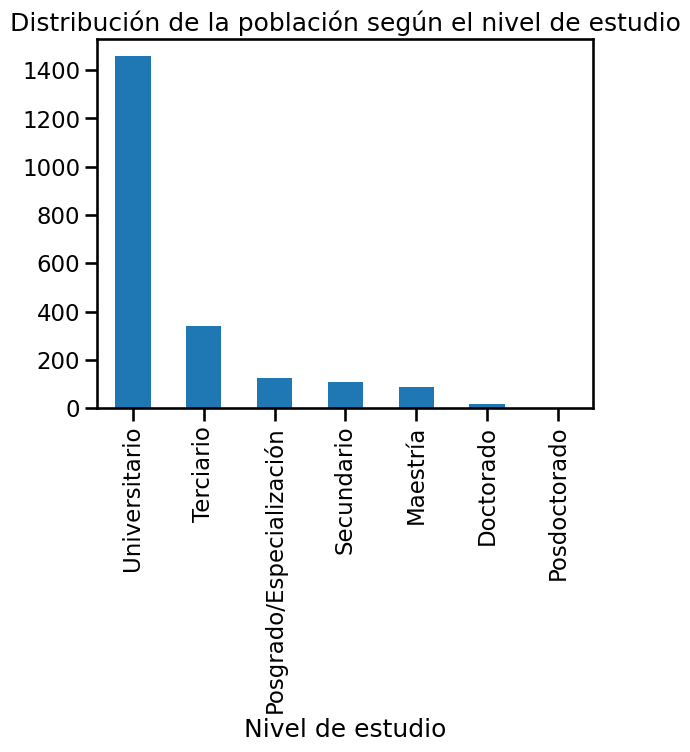

In [55]:
#Vemos la cantidad de personas acorde al nivel de estudio que tienen.

# Contar el número de observaciones en cada categoría de nivel de estudio.
counts = df['profile_studies_level'].value_counts()

# Graficamos los resultados.
counts.plot(kind='bar')
plt.title('Distribución de la población según el nivel de estudio')
plt.xlabel('Nivel de estudio')

plt.show()




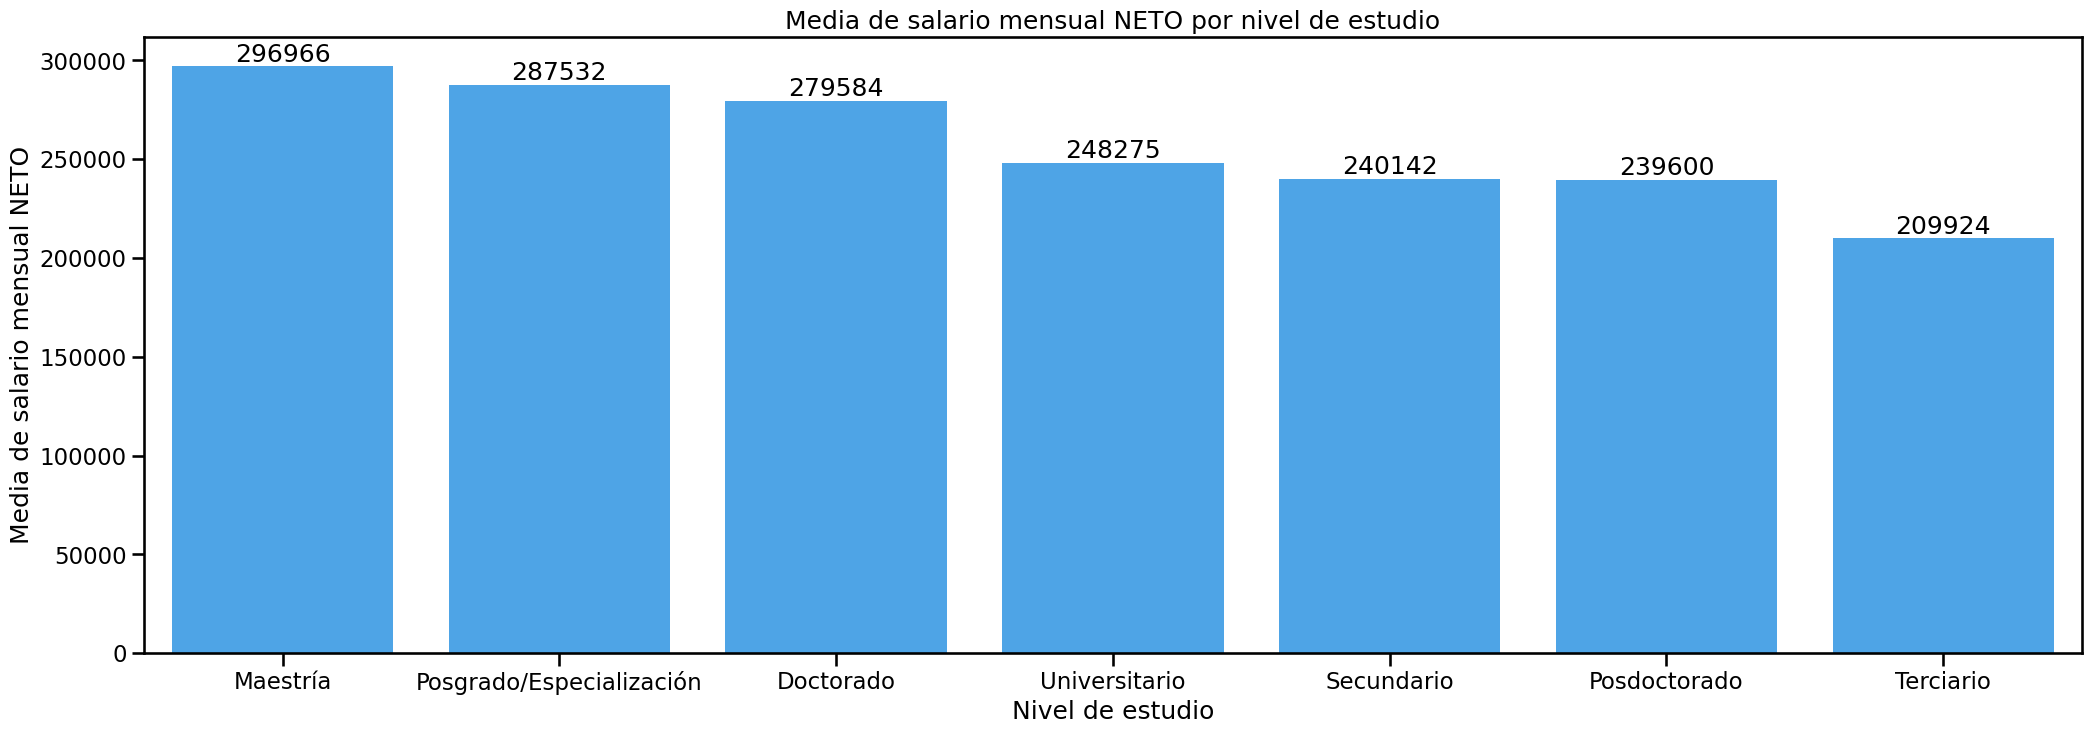

In [56]:
# Agrupar el dataframe por nivel de estudio y calcular la media del salario mensual neto para cada grupo
salary_per_study_level = df.groupby('profile_studies_level')['salary_monthly_NETO'].mean()

# Ordenar los resultados de mayor a menor según la media del salario mensual neto
salary_per_study_level = salary_per_study_level.sort_values(ascending=False)

# Graficar los resultados en un diagrama de barras
data = salary_per_study_level.reset_index()
ax = sns.barplot(data=data, x='profile_studies_level', y='salary_monthly_NETO', color='#35A7FF')
ax.figure.set_size_inches(25, 8)
for i in ax.containers:
    ax.bar_label(i, label_type='edge')
plt.ylabel('Media de salario mensual NETO')
plt.xlabel('Nivel de estudio')
plt.title('Media de salario mensual NETO por nivel de estudio')
plt.show()

In [57]:
#Creamos una nueva variable (Columna) donde se indica nivel de estudio Universitario y Terciario, 
# los que no entran en esa categoria se le coloca NA para luego eliminarlos, por no ser objeto de estudio.
df['Universitarios_Terciarios']=np.where(df['profile_studies_level']=='Universitario','Universitario',np.where(df['profile_studies_level']=='Terciario','Terciario','NA'))
pd.crosstab(df.Universitarios_Terciarios, df.profile_studies_level)#, normalize=True)

profile_studies_level,Doctorado,Maestría,Posdoctorado,Posgrado/Especialización,Secundario,Terciario,Universitario
Universitarios_Terciarios,,,,,,,
NA,17,88,2,125,107,0,0
Terciario,0,0,0,0,0,341,0
Universitario,0,0,0,0,0,0,1457


In [58]:
#Creamos una nueva variable (Columna) donde se indica nivel de estudio Universitario y Terciario, 
# los que no entran en esa categoria se le coloca NA para luego eliminarlos, por no ser objeto de estudio.
df['Universitarios_Terciarios']=np.where(df['profile_studies_level']=='Universitario','Universitario',np.where(df['profile_studies_level']=='Terciario','Terciario','NA'))
pd.crosstab(df.Universitarios_Terciarios, df.profile_studies_level)#, normalize=True)

profile_studies_level,Doctorado,Maestría,Posdoctorado,Posgrado/Especialización,Secundario,Terciario,Universitario
Universitarios_Terciarios,,,,,,,
NA,17,88,2,125,107,0,0
Terciario,0,0,0,0,0,341,0
Universitario,0,0,0,0,0,0,1457


In [59]:
salary_col='salary_monthly_NETO'
df_univ_terc=df.copy()
df_univ_terc=df_univ_terc.drop(df_univ_terc[df_univ_terc['Universitarios_Terciarios']=="NA"].index)
df_univ_terc=df_univ_terc[df_univ_terc[salary_col] < p95]
df_univ_terc.head()


,work_country,work_province,work_dedication,work_contract_type,salary_monthly_BRUTO,salary_monthly_NETO,numero,salary_in_usd,salary_last_dollar_value,salary_pay_cripto,...,profile_university,profile_boot_camp,profile_boot_camp_carrer,work_on_call_duty,salary_on_call_duty_charge,work_on_call_duty_charge_type,profile_age,profile_gender,profile_g,Universitarios_Terciarios
0,Argentina,Catamarca,Full-Time,Staff (planta permanente),300000.0,245000.0,True,NaN,NaN,NaN,...,UP - Universidad de Palermo,NaN,NaN,NaN,NaN,NaN,35,Varón Cis,Varón cis,Universitario
5,Argentina,Chaco,Full-Time,Staff (planta permanente),633000.0,395000.0,True,Cobro parte del salario en dólares,NaN,NaN,...,UNNE - Universidad Nacional Del Nordeste,NaN,NaN,NaN,NaN,NaN,31,Varón Cis,Varón cis,Universitario
6,Argentina,Chaco,Full-Time,Staff (planta permanente),110000.0,90000.0,True,Mi sueldo está dolarizado (pero cobro en moned...,125,NaN,...,Instituto Barranqueras,Informatorio Chaco,Programación web,No,0.0,Porcentaje de mi sueldo bruto,33,Varón Cis,Varón cis,Terciario
7,Argentina,Chaco,Full-Time,Staff (planta permanente),157000.0,127000.0,True,NaN,NaN,NaN,...,UCP - Universidad de la Cuenca del Plata,NaN,NaN,No,0.0,Bruto,35,Varón Cis,Varón cis,Universitario
9,Argentina,Chaco,Full-Time,Remoto (empresa de otro país),190000.0,178000.0,True,Cobro todo el salario en dólares,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,29,Varón Cis,Varón cis,Universitario


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Axes: title={'center': 'Distribución del salario (neto) según nivel de estudio Terciario y Universitario'}, xlabel='salary_monthly_NETO', ylabel='Count'>

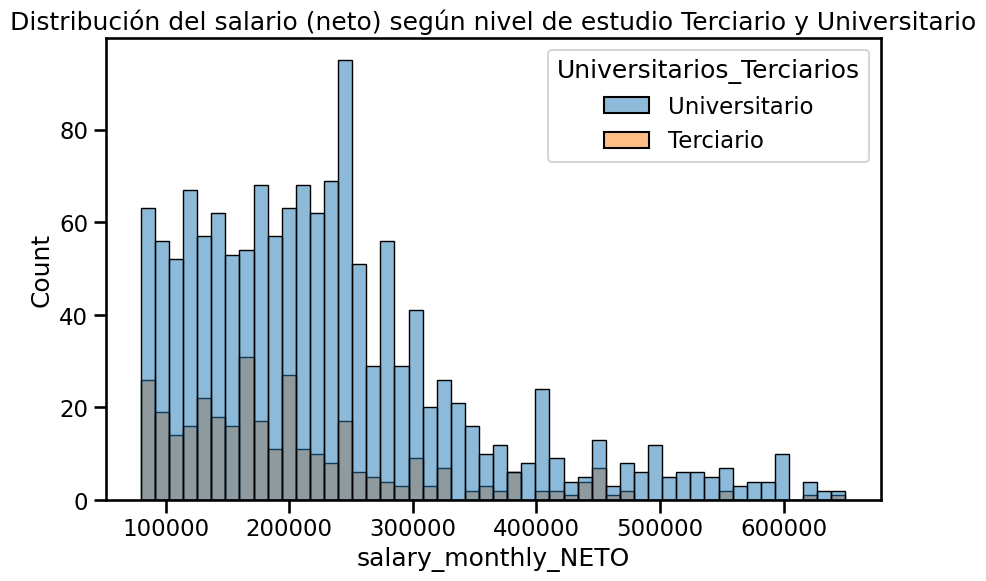

In [60]:
plt.figure(figsize=(10,6))
plt.legend(loc="right")
plt.title("Distribución del salario (neto) según nivel de estudio Terciario y Universitario", fontsize=18)
sns.histplot(df_univ_terc, x="salary_monthly_NETO", hue="Universitarios_Terciarios", bins=50)

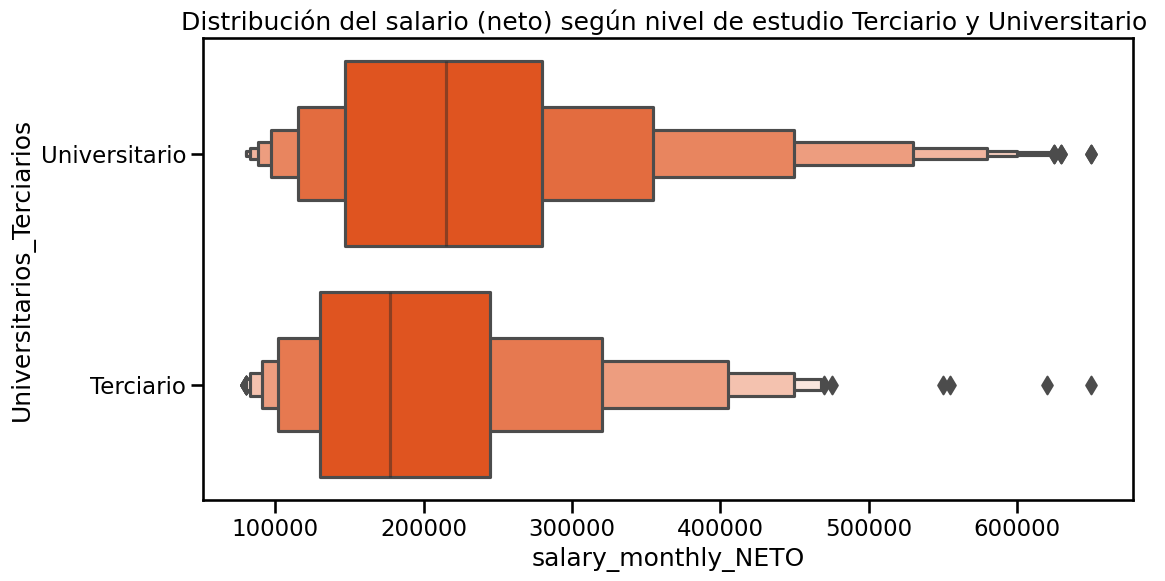

In [61]:
plt.figure(figsize=(12, 6))
plt.title("Distribución del salario (neto) según nivel de estudio Terciario y Universitario ", fontsize=18)
sns.boxenplot(data=df_univ_terc, x='salary_monthly_NETO', y='Universitarios_Terciarios',color='orangered')
plt.ticklabel_format(style='plain', axis='x')

In [62]:

# Separar la población en dos subpoblaciones según el nivel de estudio
Universitario = df[df['profile_studies_level'] == 'Universitario']
Terciario = df[df['profile_studies_level'] == 'Terciario']

# Calcular medidas de centralización y dispersión para cada subpoblación
print('Subpoblación universitaria:')
print('Media:', Universitario['salary_monthly_NETO'].mean())
print('Mediana:', Universitario['salary_monthly_NETO'].median())
print('Desviación estándar:', Universitario['salary_monthly_NETO'].std())
print('Rango intercuartil:', Universitario['salary_monthly_NETO'].quantile(0.75) - Universitario['salary_monthly_NETO'].quantile(0.25))

print('Subpoblación secundaria:')
print('Media:', Terciario['salary_monthly_NETO'].mean())
print('Mediana:', Terciario['salary_monthly_NETO'].median())
print('Desviación estándar:', Terciario['salary_monthly_NETO'].std())
print('Rango intercuartil:', Terciario['salary_monthly_NETO'].quantile(0.75) - Terciario['salary_monthly_NETO'].quantile(0.25))

Subpoblación universitaria:
Media: 248275.10964310227
Mediana: 220000.0
Desviación estándar: 142752.68423342425
Rango intercuartil: 140000.0
Subpoblación secundaria:
Media: 209924.11586510262
Mediana: 180000.0
Desviación estándar: 120534.15332343701
Rango intercuartil: 120000.0


Se puede observar que la subpoblación universitaria presenta una media ligeramente mayor que la subpoblación secundaria, pero también una desviación estándar menor, lo que indica que los datos están más concentrados alrededor de la media. Además, ambas subpoblaciones presentan un rango intercuartil similar, lo que sugiere que la dispersión de los datos es comparable en ambas subpoblaciones.

Para el analisis se agrega una nueva variable aleatoria categorica en relacion al salario neto, es "is_above_avg_salary_neto", donde se indica si el salario es mayor al promedio, lo valores posibles son "Si" y "No"

In [63]:
#Se agrega la nueva variable aleatoria is_above_avg_salary_neto

avg_salary=df_univ_terc.salary_monthly_NETO.mean()
df_univ_terc['is_above_avg_salary_neto']=np.where(df_univ_terc['salary_monthly_NETO'] > avg_salary,'Si','No')

In [64]:
#Calculo probabilidad de tener nivel de estudio Universitario
p_universitario = len(df_univ_terc[df_univ_terc['Universitarios_Terciarios']=="Universitario"]) / len(df_univ_terc)
avg_salary=df_univ_terc.salary_monthly_NETO.mean()
p_universitario

0.8078902229845626

In [65]:
#Calculo probabilidad de ganar mas que el promedio del salario neto
p_above_avg = len(df_univ_terc[df_univ_terc['salary_monthly_NETO'] >= avg_salary]) / len(df_univ_terc)
p_above_avg

0.4202401372212693

In [66]:
#Calculamos la probabilidad de ser universitario y ganar mas del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] > avg_salary
study_level_univ = df_univ_terc.Universitarios_Terciarios=="Universitario"
p_intersection_count = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count

0.3642081189251001

In [67]:
#Calculamos la probabilidad de ser terciario y ganar mas del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] > avg_salary
study_level_univ = df_univ_terc.Universitarios_Terciarios=="Terciario"
p_intersection_count_terciario = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_terciario

0.05603201829616924

In [68]:
#Calculamos la probabilidad de ser terciario y ganar menos del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] < avg_salary
study_level_univ = df_univ_terc.Universitarios_Terciarios=="Terciario"
p_intersection_count_terciario_menos = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_terciario_menos

0.13607775871926817

In [69]:
#Calculamos la probabilidad de ser universitario y ganar menos del salario neto promedio
is_above_avg = df_univ_terc['salary_monthly_NETO'] < avg_salary
study_level_univ = df_univ_terc.Universitarios_Terciarios=="Universitario"
p_intersection_count_menos = len(df_univ_terc[is_above_avg & study_level_univ])/len(df_univ_terc)
p_intersection_count_menos

0.44368210405946257

Verificamos la condicion de independencia planteada. Responderemos las siguientes preguntas
¿Considera que ambas variables son independientes? ¿Qué analizaría al respecto? Se realiza el siguiente planteo:

Sean A y B se dicen conjuntos independientes si:

P(A∩B)=P(A)P(B)

Calculamos la probabilidad de ser universitario y ganar mas del salario neto promedio.

P(A∩B)=0.3953

P(A)P(B)=0.7994 x 0.4651 =0.3718

No se cumple la condicion de independencia, por lo que puede ser que esten relacionadas estas variables.

P(B)!=0 -> P(A|B)=P(A)

donde P(A|B)=P(A∩B)/P(B)


Podemos hacer entonces el Test Chi-Cuadrado p/ independencia de v.a. categóricas para poder evaluar la relación entre estas variables:

Hipotesis a analizar: 
H0=”Las variables son independientes”

H1=”Estan relacionadas ambas variables”

In [70]:
from scipy.stats import chi2_contingency

# Crear tabla de contingencia
contingency_table = pd.crosstab(df_univ_terc.Universitarios_Terciarios, df_univ_terc.is_above_avg_salary_neto)#, margins=true)

contingency_table

is_above_avg_salary_neto,No,Si
Universitarios_Terciarios,,
Terciario,238,98
Universitario,776,637


In [71]:
test= chi2_contingency(contingency_table)

#los valores esperados son:
esperados = pd.DataFrame(test[3])
esperados

,0,1
0,194.799314,141.200686
1,819.200686,593.799314


In [72]:
test

Chi2ContingencyResult(statistic=27.569722932487206, pvalue=1.5153227819698486e-07, dof=1, expected_freq=array([[194.79931389, 141.20068611],
       [819.20068611, 593.79931389]]))

In [73]:
#P-Valor
print ("el P valor es:", test[1])

el P valor es: 1.5153227819698486e-07


Tomando un nivel de significancia aplha=0,05 y contrastando con el P-valor obtenido se concluye que se rechaza la hipotesis H0, las variables comparadas no son independientes.

Calculo de medidas de centralizacion y dispersion para cada subpoblacion.

In [74]:
#calculamos la media, mediana y maximo del Salario Neto con nivel estudio Terciario
medidas_centralizacion_univ=df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Terciario'].salary_monthly_NETO.mean(), df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Terciario'].salary_monthly_NETO.median(), df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Terciario'].salary_monthly_NETO.max()
print("Media, Mediana, Maximo")
medidas_centralizacion_univ

Media, Mediana, Maximo


(202030.12949404758, 177450.0, 650000.0)

In [75]:
#Medidas de dispersion
df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Universitario'].salary_monthly_NETO.describe()

count      1413.000000
mean     232922.753227
std      114452.026635
min       80000.000000
25%      147000.000000
50%      215000.000000
75%      280000.000000
max      650000.000000
Name: salary_monthly_NETO, dtype: float64

In [76]:
df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Terciario'].salary_monthly_NETO.describe()

count       336.000000
mean     202030.129494
std      102209.027184
min       80000.000000
25%      130000.000000
50%      177450.000000
75%      245000.000000
max      650000.000000
Name: salary_monthly_NETO, dtype: float64

In [77]:
import scipy.stats
print("Coeficiente de variación salario neto de los Terciario",
      scipy.stats.variation(df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Terciario'].salary_monthly_NETO))
print("Coeficiente de variación salario neto de los Universitarios",
      scipy.stats.variation(df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Universitario'].salary_monthly_NETO.dropna()))

Coeficiente de variación salario neto de los Terciario 0.5051564206619206
Coeficiente de variación salario neto de los Universitarios 0.4911994136512371


C:\Users\Elesefoo\AppData\Local\Temp\ipykernel_1020\2146463011.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Terciario'].salary_monthly_NETO)


<Axes: title={'center': 'Distribucion Personas con Estudios Terciario segun el Salario Neto'}, xlabel='salary_monthly_NETO', ylabel='Density'>

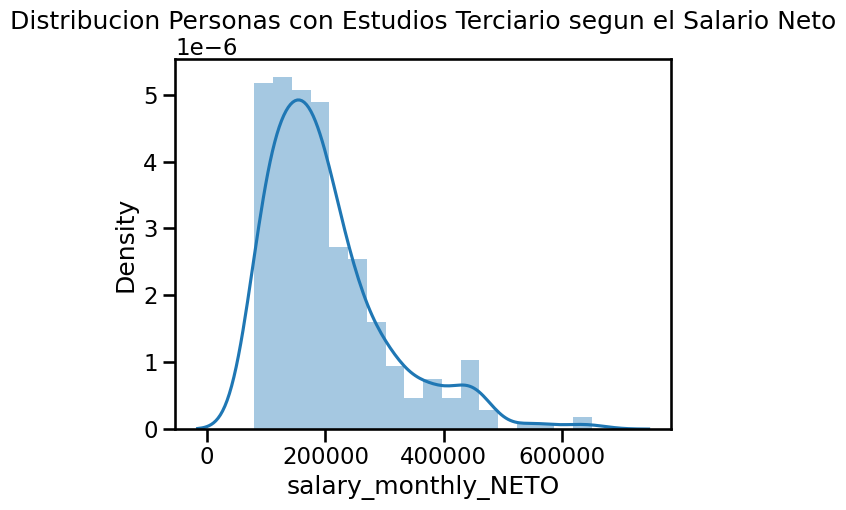

In [90]:
plt.title("Distribucion Personas con Estudios Terciario segun el Salario Neto")
sns.distplot(df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Terciario'].salary_monthly_NETO)

C:\Users\Elesefoo\AppData\Local\Temp\ipykernel_1020\1852455059.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Universitario'].salary_monthly_NETO)


<Axes: title={'center': 'Distribucion Personas con Estudios Universitarios segun el Salario Neto'}, xlabel='salary_monthly_NETO', ylabel='Density'>

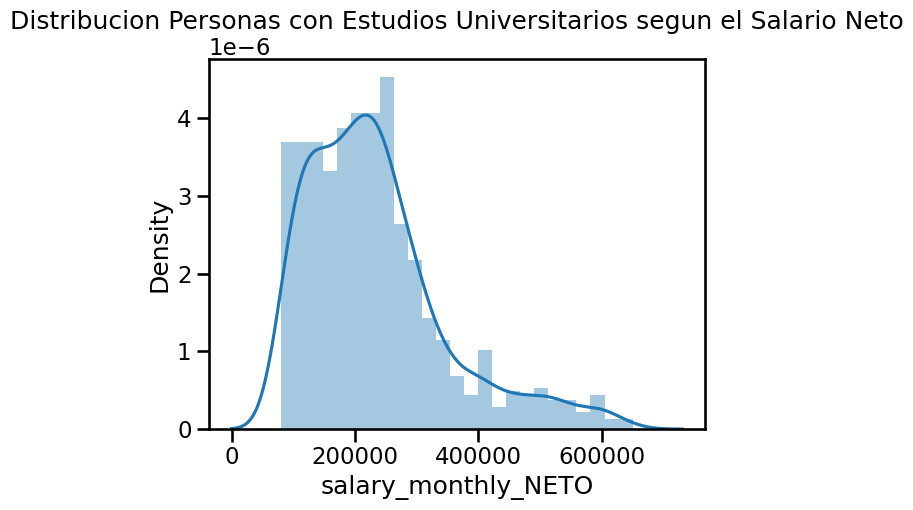

In [79]:
plt.title("Distribucion Personas con Estudios Universitarios segun el Salario Neto")
sns.distplot(df_univ_terc[df_univ_terc['Universitarios_Terciarios']=='Universitario'].salary_monthly_NETO)

En general se observa que ambas subpoblaciones tienen distribuciones similares con desviacion estandar y coeficiente de variacion aproximadas respecto al salario neto. La subpoblacion Universitarios tiene mas personas dentro de los encuestados. En promedio los Universitarios tienen mayor sueldo que los Terciarios.

## d) Densidad Conjunta condicional

Elija dos variables numéricas y una categórica. 
Estudie la dispersión (scatterplot) de las dos variables discriminando en color por la variable categórica (ayuda: hue en seaborn)


In [80]:
df.profile_g.unique()

array(['Varón cis', 'Mujer cis', 'Diversidades'], dtype=object)

In [81]:
df_under_100 = df[df['profile_age'] < 100]

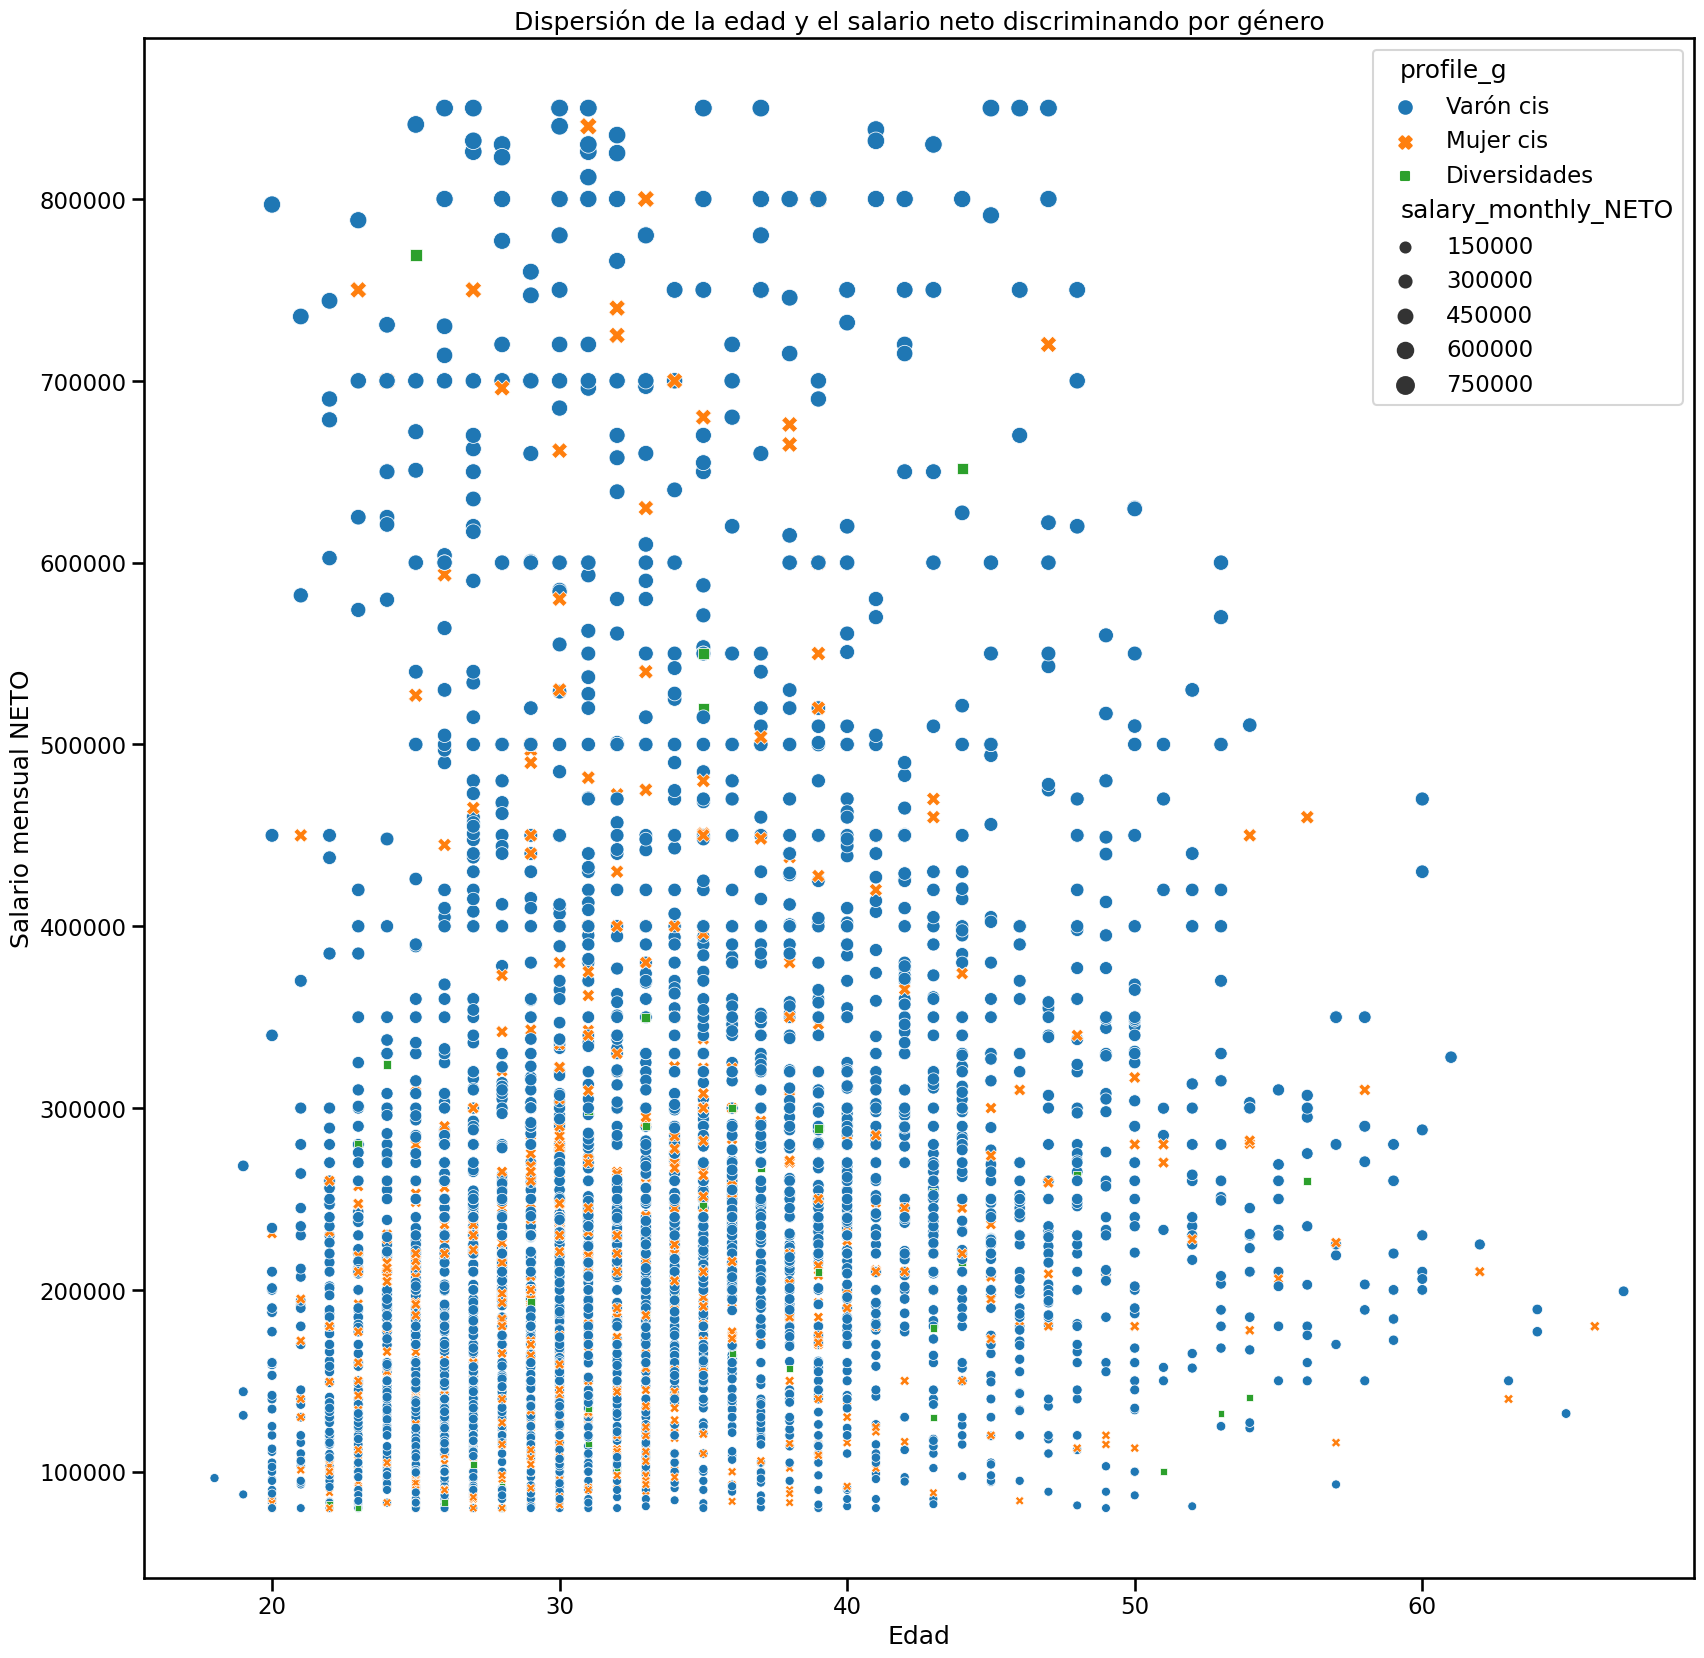

In [82]:
# Crear un gráfico de dispersión con los datos de salario neto y edad, discriminando por género
plt.figure(figsize=(20,20))
sns.scatterplot(x='profile_age', 
                y='salary_monthly_NETO', 
                hue='profile_g', 
                data=df_under_100, 
                size='salary_monthly_NETO',
                style='profile_g'
                )



# Configurar los ejes y el título del gráfico

plt.xlabel('Edad')
plt.ylabel('Salario mensual NETO')
plt.title('Dispersión de la edad y el salario neto discriminando por género')

# Mostrar el gráfico
plt.show()

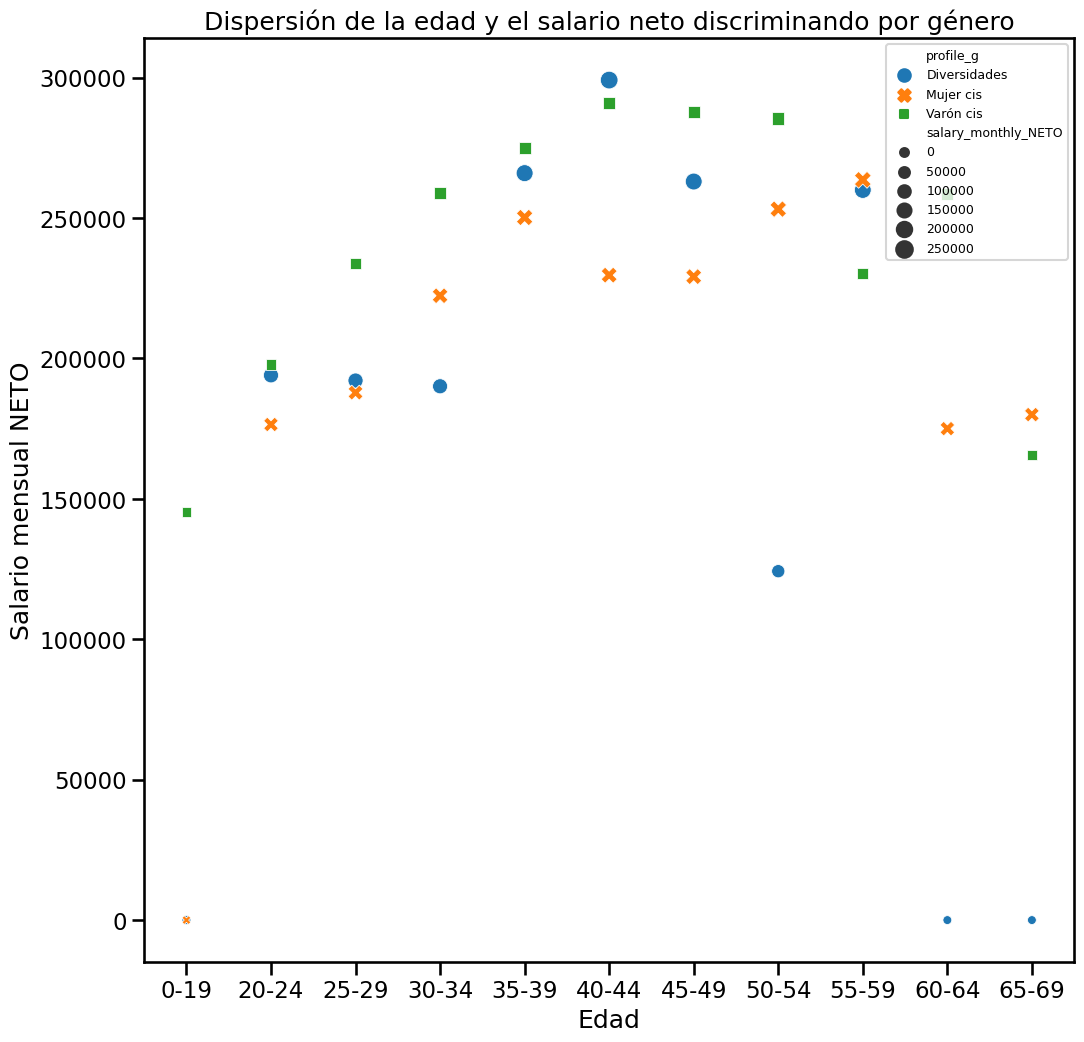

In [83]:
labels = ['0-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64','65-69']
df_under_100['age_group'] = pd.cut(df_under_100['profile_age'],bins=[0,19,24,29,34,39,44,49,54,59,64,69],labels=labels)
to_plot = df_under_100.groupby(['profile_g','age_group']).agg({'salary_monthly_NETO':'mean'}).fillna(0)

# Crear un gráfico de dispersión con los datos de salario neto y edad, discriminando por género
plt.figure(figsize=(12,12))
sns.scatterplot(x='age_group', 
                y='salary_monthly_NETO', 
                hue='profile_g', 
                data=to_plot.reset_index(), 
                size='salary_monthly_NETO',
                style='profile_g')


# Configurar los ejes y el título del gráfico
plt.legend(loc='upper right',prop={'size':9})
plt.xlabel('Edad')
plt.ylabel('Salario mensual NETO')
plt.title('Dispersión de la edad y el salario neto discriminando por género')

# Mostrar el gráfico
plt.show()

Al ver de manera conjunta salario promedio vs edad vs género, priori, parecería que en general todos los casos siguen una curva cóncava. Es decir, curvas con tramos crecientes que llegan a un máximo al rededor de los 40 años y luego empieza a decrecer. Específicamente en el caso de mujeres cis en el grupo de 40-44 el salario promedio cae. Sería interesante identificar la causa de esa caída, que luego parece recuperarse. Sin embargo, a partir de la foto que tenemos parece que las mujeres ganan en promedio menos que los hombres. En el caso de diversidades no queda tan claro.